# Uniswap V3 EMA strategy


## Advanced statistics

- This is the first notebook to demonstrate the use of the advanced statstics, which are added using the [quantstats](https://github.com/ranaroussi/quantstats) package.
- In order for this to work, we need to use `poetry install -E quantstats`. Add flags for any other extras you require. Alternatively, you can use `poetry install --all-extras` 

In [26]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use

trading_strategy_engine_version = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
trading_strategy_type = StrategyType.managed_positions

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
trade_routing = TradeRouting.uniswap_v3_usdc

# How often the strategy performs the decide_trades cycle.
# We do it for every 16h.
trading_strategy_cycle = CycleDuration.cycle_16h

# Strategy keeps its cash in BUSD
reserve_currency = ReserveCurrency.usdc

# Time bucket for our candles
candle_time_bucket = TimeBucket.h4

# Which chain we are trading
chain_id = ChainId.ethereum

# Which exchange we are trading on.
exchange_slug = "uniswap-v3"

# Which trading pair we are trading
trading_pair_ticker = ("WETH", "USDC", 5)

# How much of the cash to put on a single trade
position_size = 0.10

#
# Strategy thinking specific parameter
#

batch_size = 90

slow_ema_candle_count = 15

fast_ema_candle_count = 5


# Range of backtesting and synthetic data generation.
# Because we are using synthetic data actual dates do not really matter -
# only the duration

start_at = datetime.datetime(2021, 6, 1)

end_at = datetime.datetime(2022, 1, 1)

# Start with 10,000 USD
initial_deposit = 10_000


In [27]:
from typing import List, Dict

from pandas_ta.overlap import ema

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradingstrategy.universe import Universe


def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle.

    - Reads incoming execution state (positions, past trades)

    - Reads the current universe (candles)

    - Decides what to do next

    - Outputs strategy thinking for visualisation and debug messages

    :param timestamp:
        The Pandas timestamp object for this cycle. Matches
        trading_strategy_cycle division.
        Always truncated to the zero seconds and minutes, never a real-time clock.

    :param universe:
        Trading universe that was constructed earlier.

    :param state:
        The current trade execution state.
        Contains current open positions and all previously executed trades, plus output
        for statistics, visualisation and diangnostics of the strategy.

    :param pricing_model:
        Pricing model can tell the buy/sell price of the particular asset at a particular moment.

    :param cycle_debug_data:
        Python dictionary for various debug variables you can read or set, specific to this trade cycle.
        This data is discarded at the end of the trade cycle.

    :return:
        List of trade instructions in the form of :py:class:`TradeExecution` instances.
        The trades can be generated using `position_manager` but strategy could also hand craft its trades.
    """

    # The pair we are trading
    pair = universe.pairs.get_single()

    # How much cash we have in the hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=batch_size)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close = candles["close"]

    # Calculate exponential moving averages based on slow and fast sample numbers.
    slow_ema_series = ema(close, length=slow_ema_candle_count)
    fast_ema_series = ema(close, length=fast_ema_candle_count)

    if slow_ema_series is None or fast_ema_series is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting
        return []

    slow_ema = slow_ema_series.iloc[-1]
    fast_ema = fast_ema_series.iloc[-1]

    # Get the last close price from close time series
    # that's Pandas's Series object
    # https://pandas.pydata.org/docs/reference/api/pandas.Series.iat.html
    current_price = close.iloc[-1]

    # List of any trades we decide on this cycle.
    # Because the strategy is simple, there can be
    # only zero (do nothing) or 1 (open or close) trades
    # decides
    trades = []

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)

    if current_price >= slow_ema:
        # Entry condition:
        # Close price is higher than the slow EMA
        if not position_manager.is_any_open():
            buy_amount = cash * position_size
            trades += position_manager.open_1x_long(pair, buy_amount)
    elif fast_ema >= slow_ema:
        # Exit condition:
        # Fast EMA crosses slow EMA
        if position_manager.is_any_open():
            trades += position_manager.close_all()

    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "Slow EMA", PlotKind.technical_indicator_on_price, slow_ema, colour="darkblue")
    visualisation.plot_indicator(timestamp, "Fast EMA", PlotKind.technical_indicator_on_price, fast_ema, colour="#003300")

    return trades

In [28]:
from typing import Optional
from tradeexecutor.strategy.trading_strategy_universe import load_all_data, TradingStrategyUniverse, \
    load_pair_data_for_single_exchange
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradingstrategy.client import Client
from tradeexecutor.strategy.universe_model import UniverseOptions
import datetime

def create_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options = UniverseOptions(),
) -> TradingStrategyUniverse:
    """Creates the trading universe where the strategy trades.

    If `execution_context.live_trading` is true then this function is called for
    every execution cycle. If we are backtesting, then this function is
    called only once at the start of backtesting and the `decide_trades`
    need to deal with new and deprecated trading pairs.

    As we are only trading a single pair, load data for the single pair only.

    :param ts:
        The timestamp of the trading cycle. For live trading,
        `create_trading_universe` is called on every cycle.
        For backtesting, it is only called at the start

    :param client:
        Trading Strategy Python client instance.

    :param execution_context:
        Information how the strategy is executed. E.g.
        if we are live trading or not.

    :param candle_timeframe_override:
        Allow the backtest framework override what candle size is used to backtest the strategy
        without editing the strategy Python source code file.

    :return:
        This function must return :py:class:`TradingStrategyUniverse` instance
        filled with the data for exchanges, pairs and candles needed to decide trades.
        The trading universe also contains information about the reserve asset,
        usually stablecoin, we use for the strategy.
    """

    # Load all datas we can get for our candle time bucket
    dataset = load_pair_data_for_single_exchange(
        client,
        execution_context,
        candle_time_bucket,
        chain_id,
        exchange_slug,
        [trading_pair_ticker],
        universe_options = universe_options,
        )

    # Filter down to the single pair we are interested in
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        chain_id,
        exchange_slug,
        trading_pair_ticker[0],
        trading_pair_ticker[1],
    )

    return universe

In [29]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/alexurbs/.tradingstrategy


In [30]:
import logging

from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="BNB/USD EMA crossover example",
    start_at=start_at,
    end_at=end_at,
    client=client,
    cycle_duration=trading_strategy_cycle,
    decide_trades=decide_trades,
    create_trading_universe=create_trading_universe,
    initial_deposit=initial_deposit,
    reserve_currency=reserve_currency,
    trade_routing=trade_routing,
    log_level=logging.WARNING,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Loading OHLCV data for WETH-USDC:   0%|          | 0/59211740 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 41 trades


In [31]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 21
Trades made: 41


In [32]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

# Basic summary statistics

- Here we show the basic stats that are calculated without using any external packages 

Note: for the advanced stats to work later, we need to provide the `state` argument to `calculate_summary_statistics()`

In [33]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics(state=state)

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

0
Trading period length                     209 days
Return %                                     7.35%
Annualised return %                         12.82%
Cash at start                           $10,000.00
Value at end                            $10,735.02
Trade volume                            $43,715.51
Trade win percent                           55.00%
Total positions                                 20
Won trades                                      11
Lost trades                                      9
Stop losses triggered                            0
Stop loss % of all                           0.00%
Stop loss % of lost                          0.00%
Take profits triggered                           0
Take profit % of all                         0.00%
Take profit % of win                         0.00%
Zero profit trades                               0
Positions open at the end                        1
Realised profit and loss                   $735.02
Portfolio unrealised value               $1,073.50
Extra returns on lending pool interest       $0.00
Cash left at the end                     $9,661.52
Average winning trade profit %              10.98%
Average losing trade loss %                 -5.38%
Biggest winning trade %                     36.78%
Biggest losing trade %                     -19.43%
Average duration of winning trades          8 days
Average duration of losing trades           8 days
LP fees paid                                $21.86
LP fees paid % of volume                     0.05%
Average trade:                               3.62%
Median trade:                                1.71%
Consecutive wins                                 3
Consecutive losses                               2
Biggest realized risk                       -1.94%
Avg realised risk                           -0.54%
Max pullback of total capital               -1.98%
Max loss risk at opening of position        10.00%

## Advanced statistics

- The following code block demonstrates how to see advanced statistics. 
- Note that there may be small differences between the same statistics in the basic summary stats shown above the advanced stats shown below. This is because we use resampling to convert an irregular timeline into a daily timeline that is suitable for the quantstats package.
- Recall that you need to add the quantstats flag to your poetry install command e.g. `poetry install -E quantstats`, otherwise nothing will show

There are currently 4 methods that we have provided to easily see more advanced details. These are:

1. get_full_report()
2. get_full_stats()
3. get_basic_stats()
4. get_basic_plots()
5. get_full_plots()

`get_full_report()` provides all the statistics and plots that are available to see. `full` in the method name indicates it will show both advanced and basic details. It is not possible to only show advanced details. 

                           Strategy
-------------------------  ----------
Start Period               2021-05-31
End Period                 2021-12-31
Risk-Free Rate             0.0%
Time in Market             90.0%

Cumulative Return          6.58%
CAGR﹪                     11.48%

Sharpe                     1.25
Prob. Sharpe Ratio         87.75%
Smart Sharpe               1.16
Sortino                    1.95
Smart Sortino              1.8
Sortino/√2                 1.38
Smart Sortino/√2           1.27
Omega                      1.26

Max Drawdown               -3.95%
Longest DD Days            59
Volatility (ann.)          6.1%
Calmar                     2.91
Skew                       0.16
Kurtosis                   1.88

Expected Daily %           0.03%
Expected Monthly %         0.8%
Expected Yearly %          6.58%
Kelly Criterion            10.25%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.6%
Expected Shortfall (cVaR)  -0.6%

Max Consecutive Wins       5
Max Co

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2021-06-04  2021-06-26  2021-08-02    59     -3.950795         -3.642446
2  2021-12-02  2021-12-30  2021-12-31    29     -2.419735         -2.248794
3  2021-09-17  2021-09-28  2021-10-14    27     -2.239955         -2.150244
4  2021-08-12  2021-08-18  2021-08-31    19     -1.015868         -0.919637
5  2021-10-22  2021-10-24  2021-11-03    12     -0.984026         -0.666979

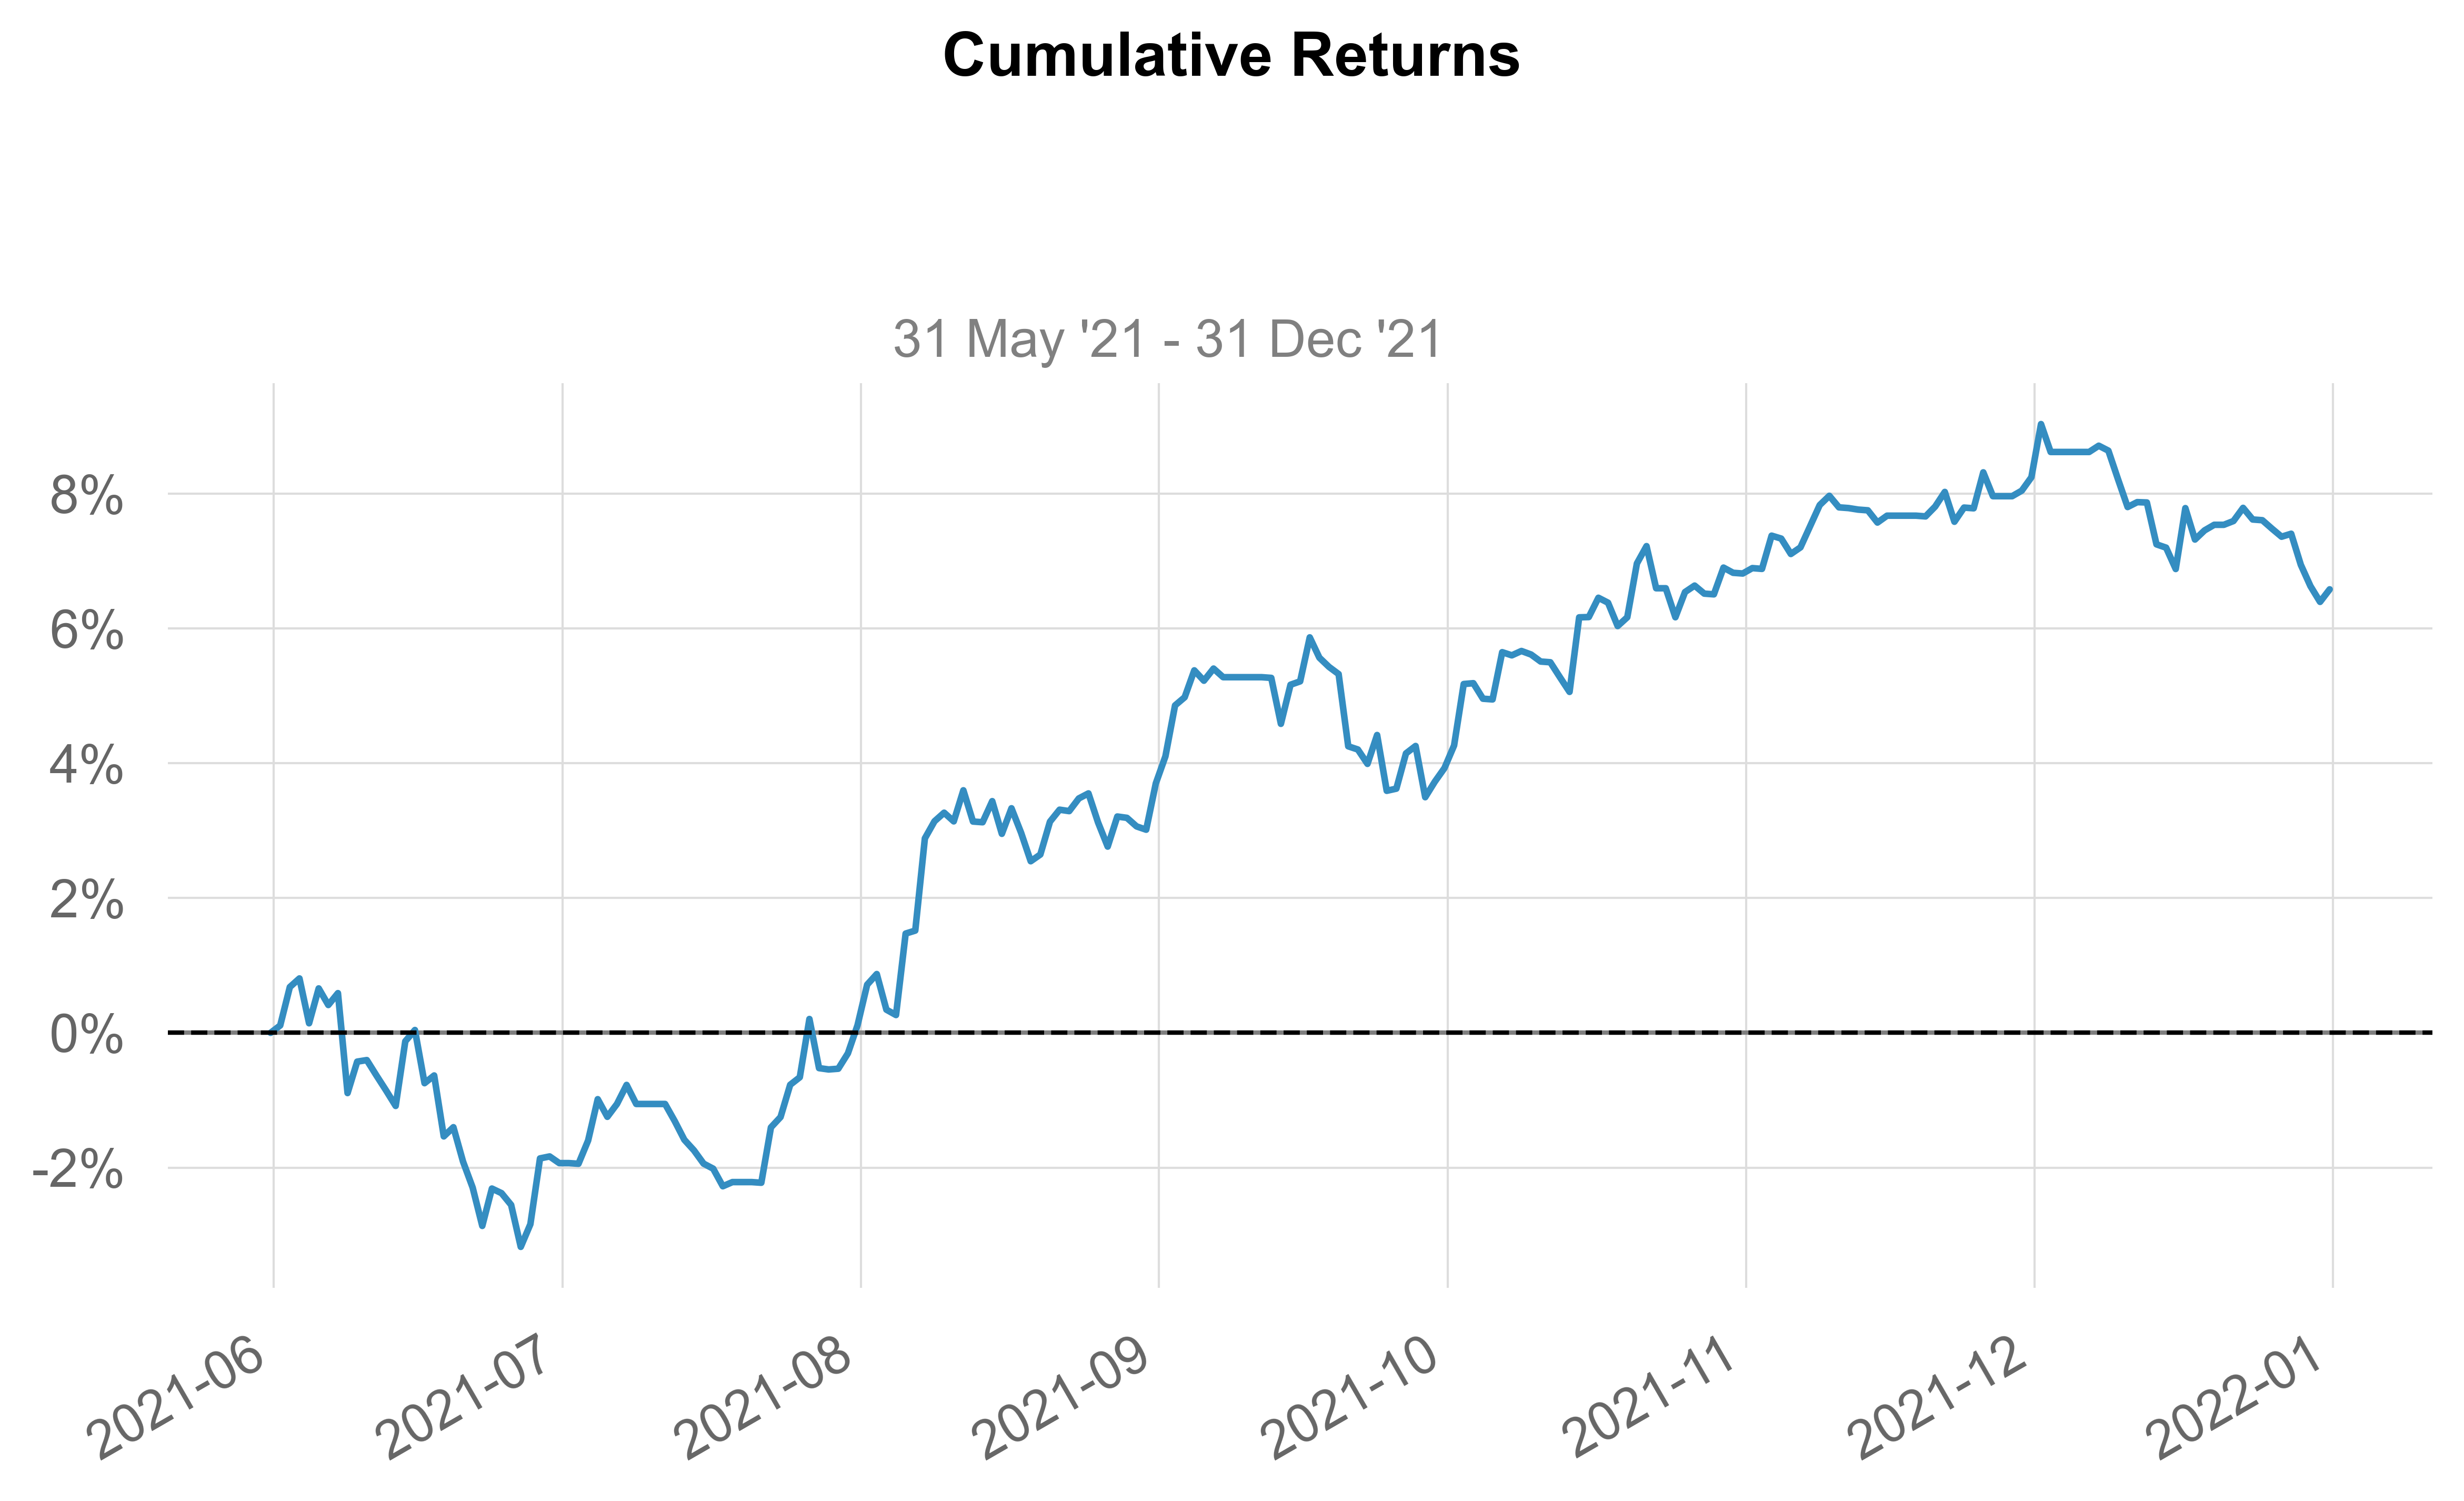

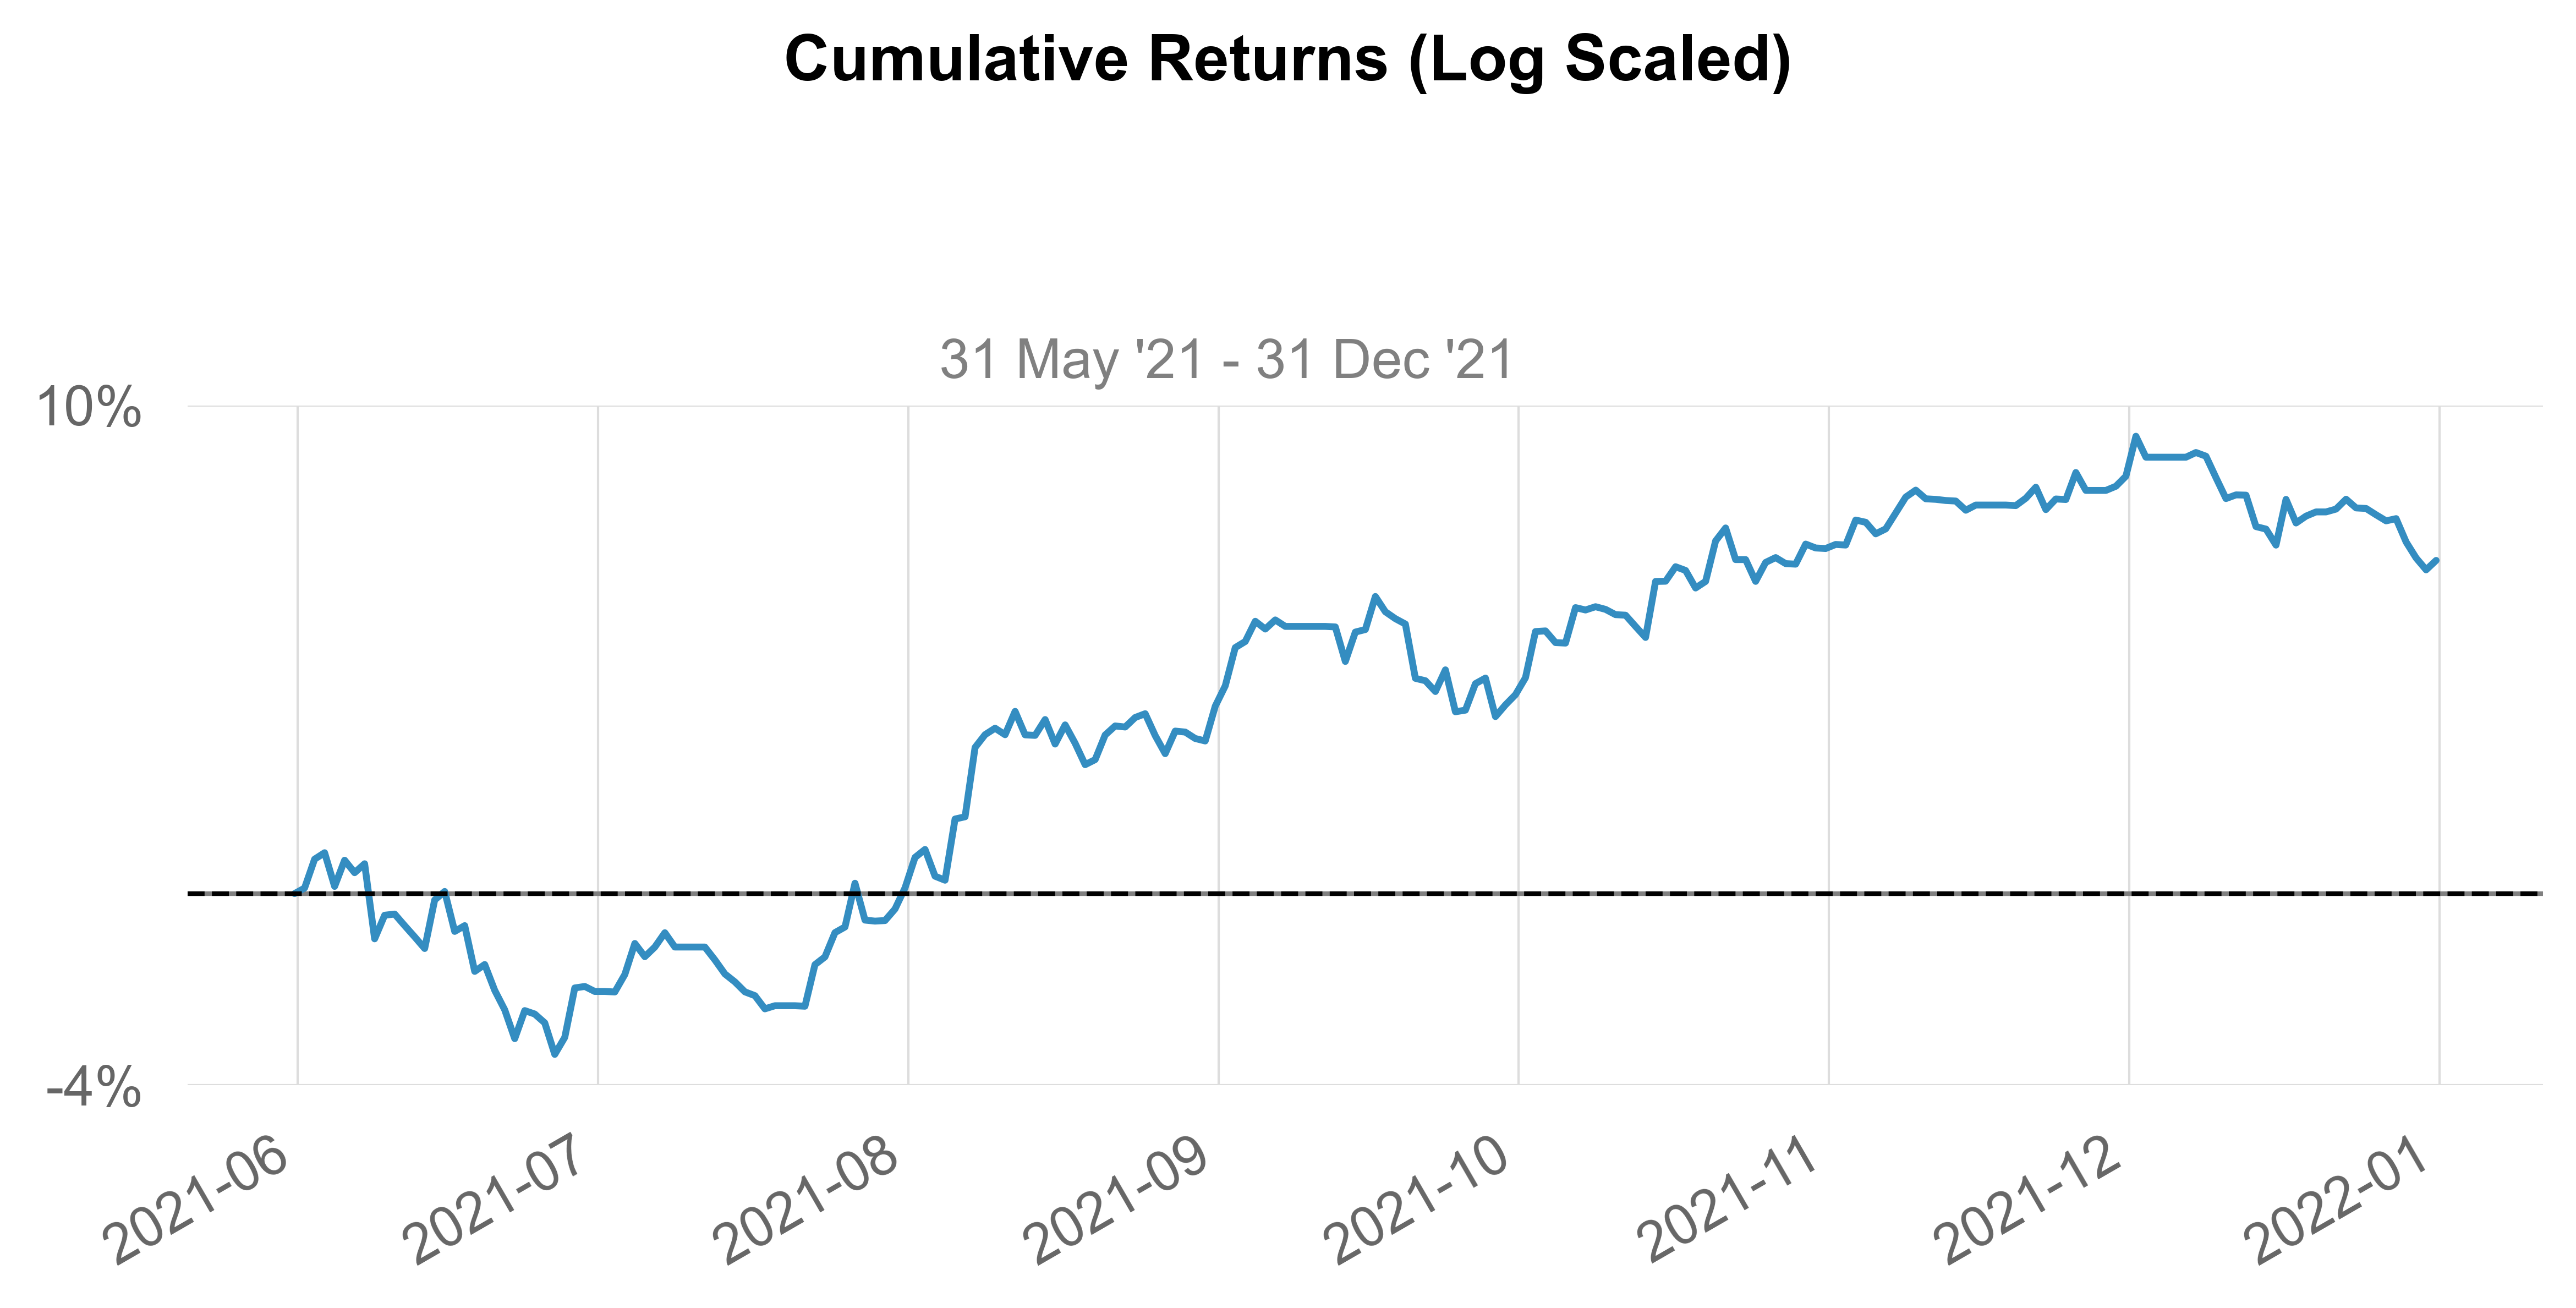

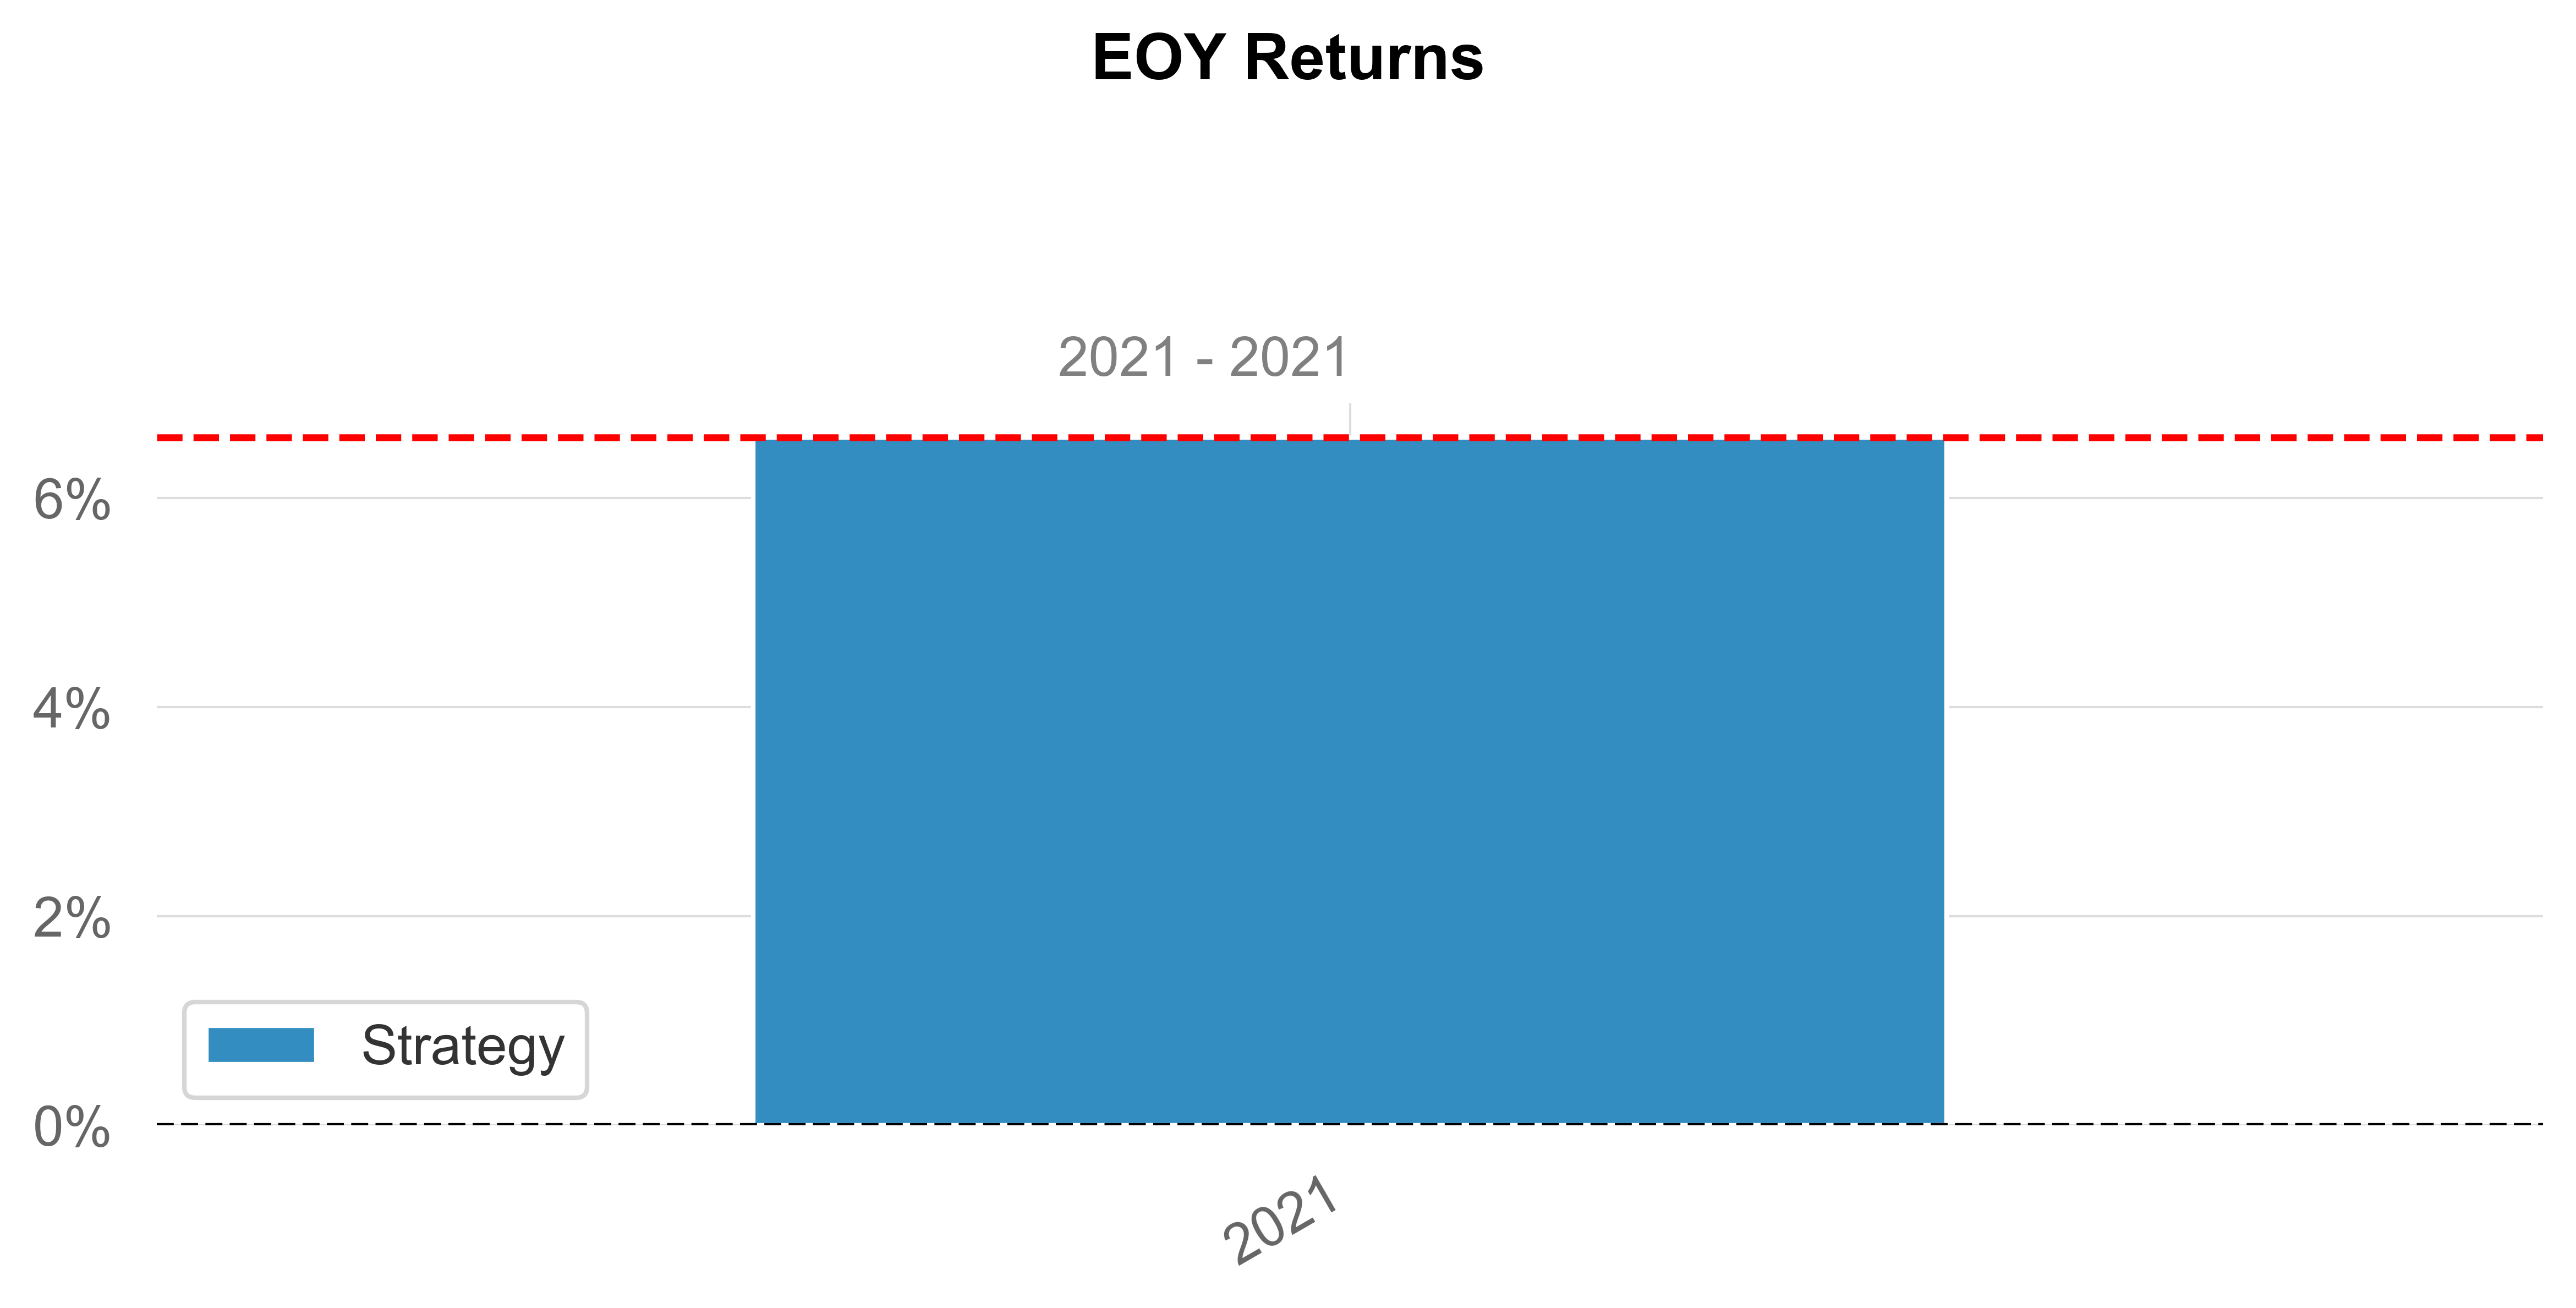

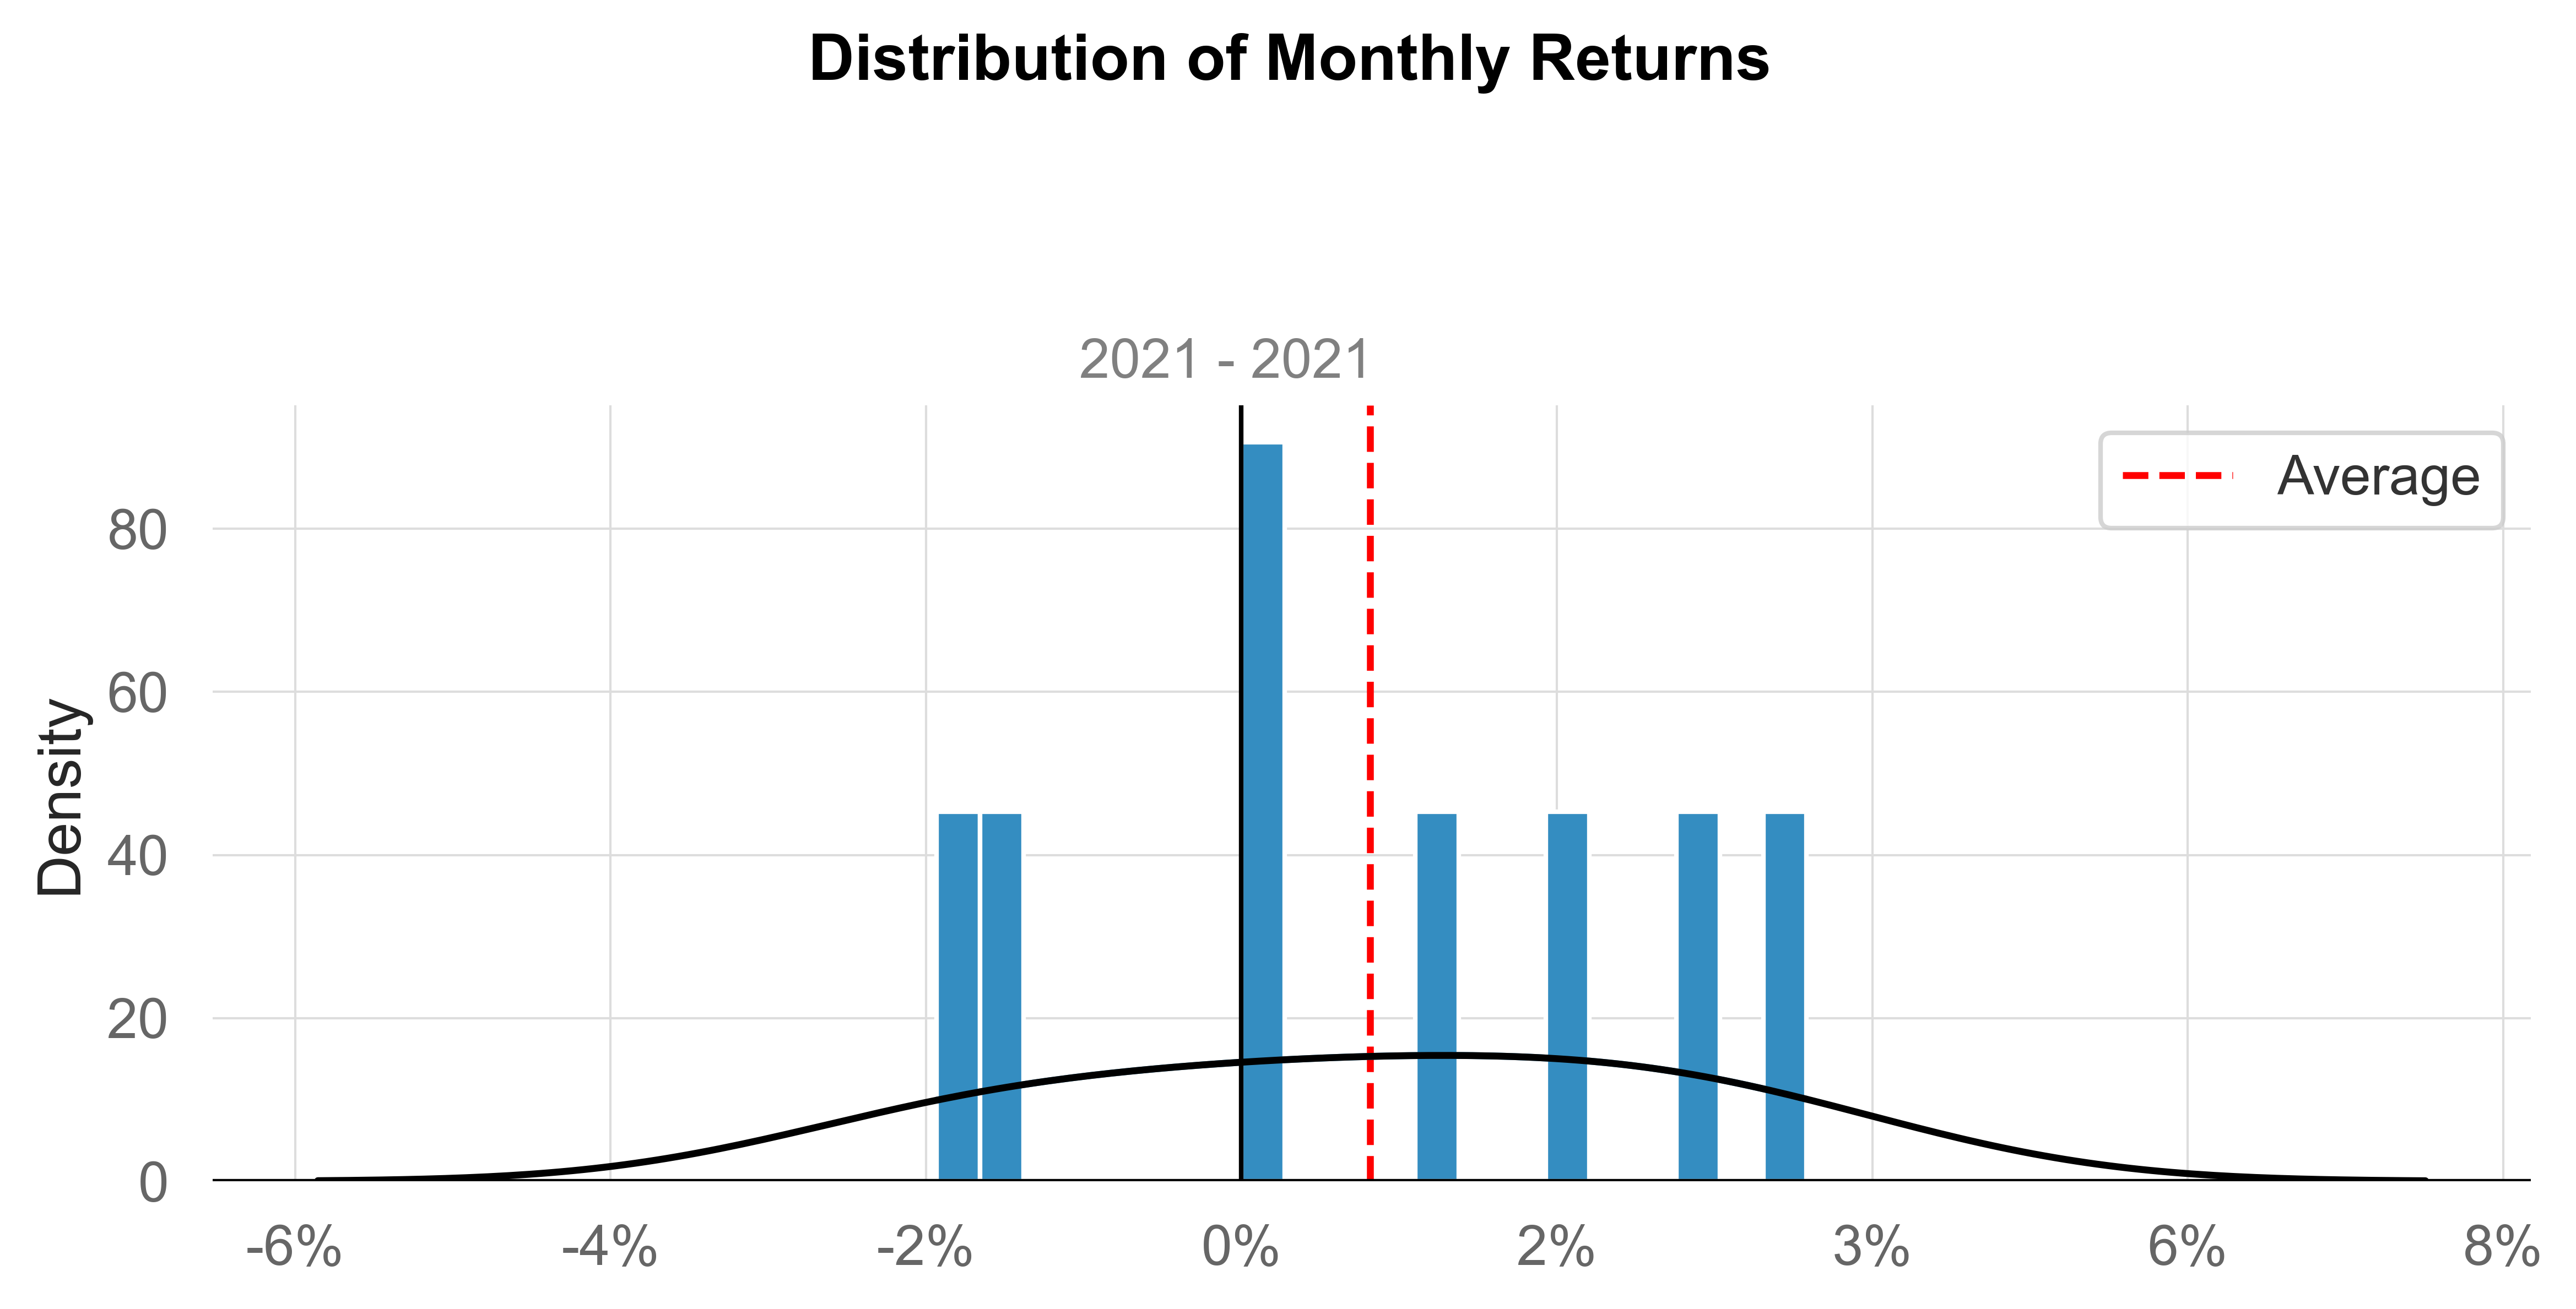

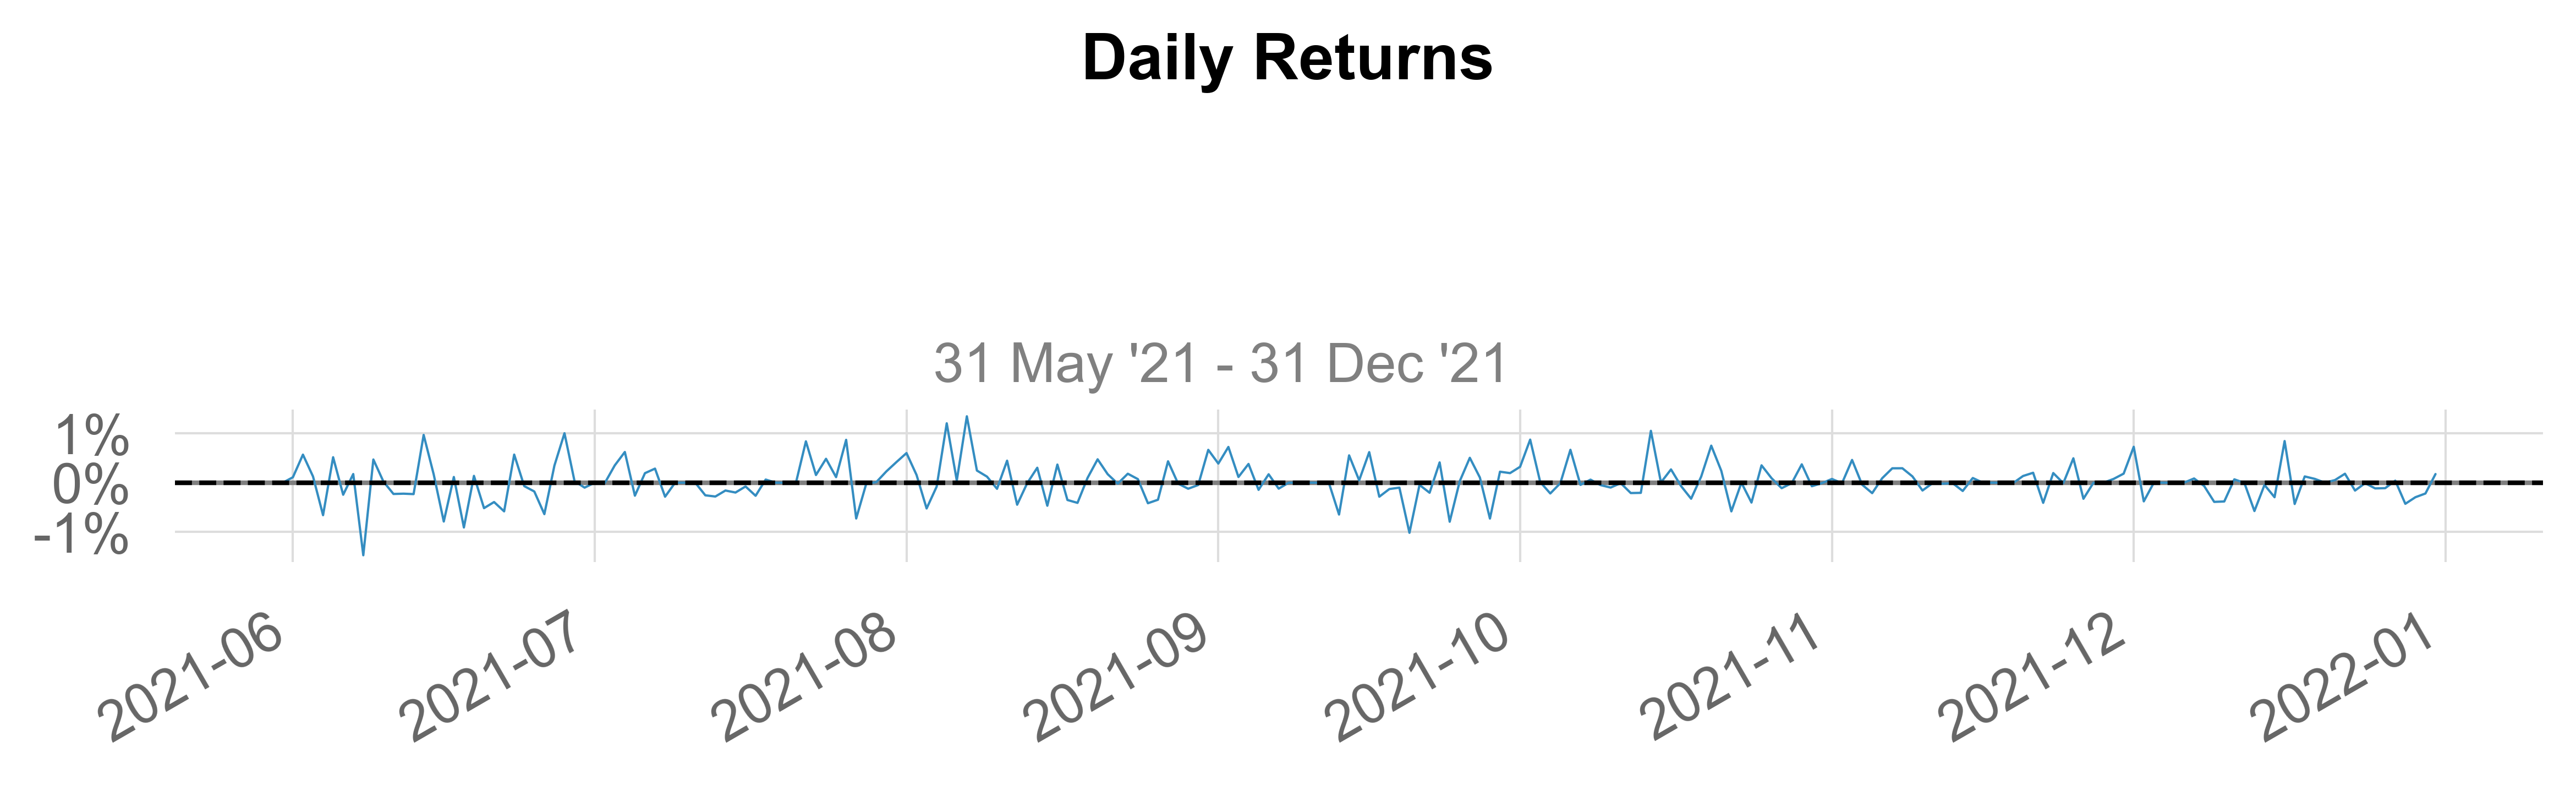

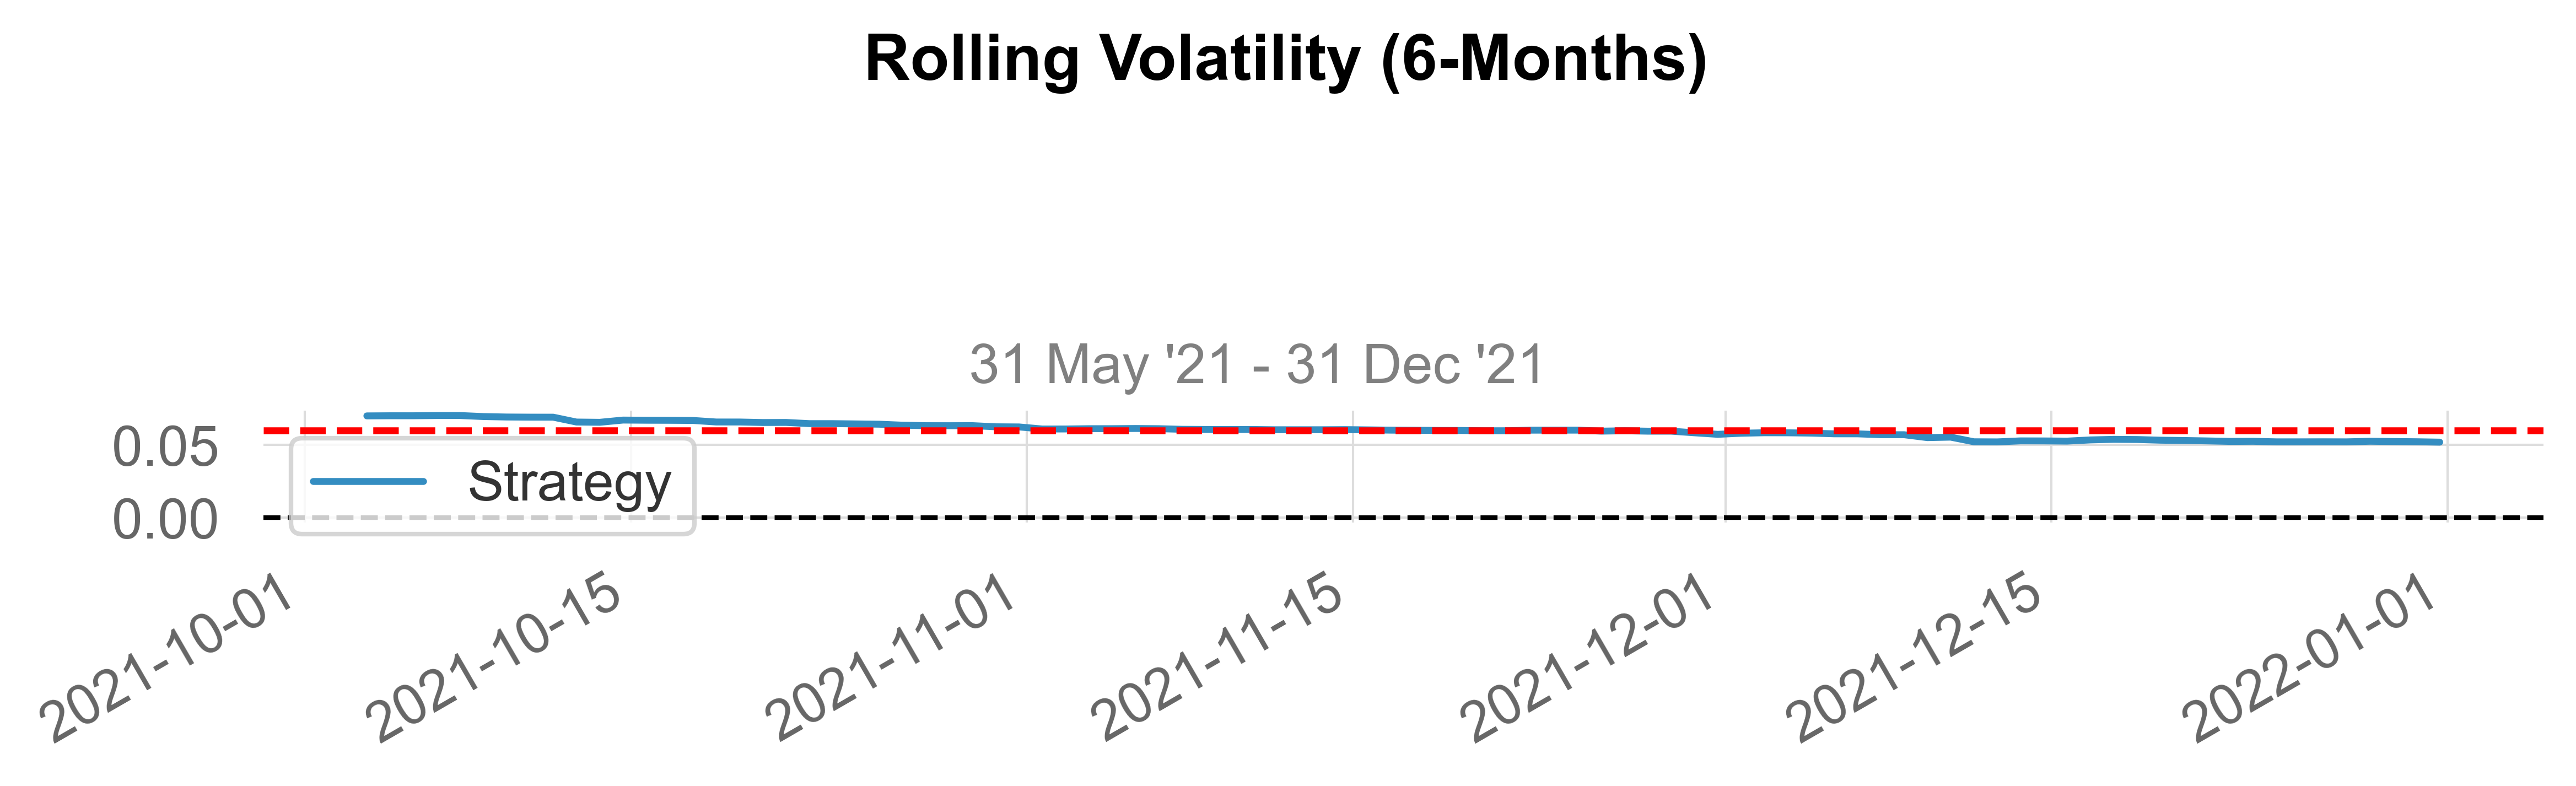

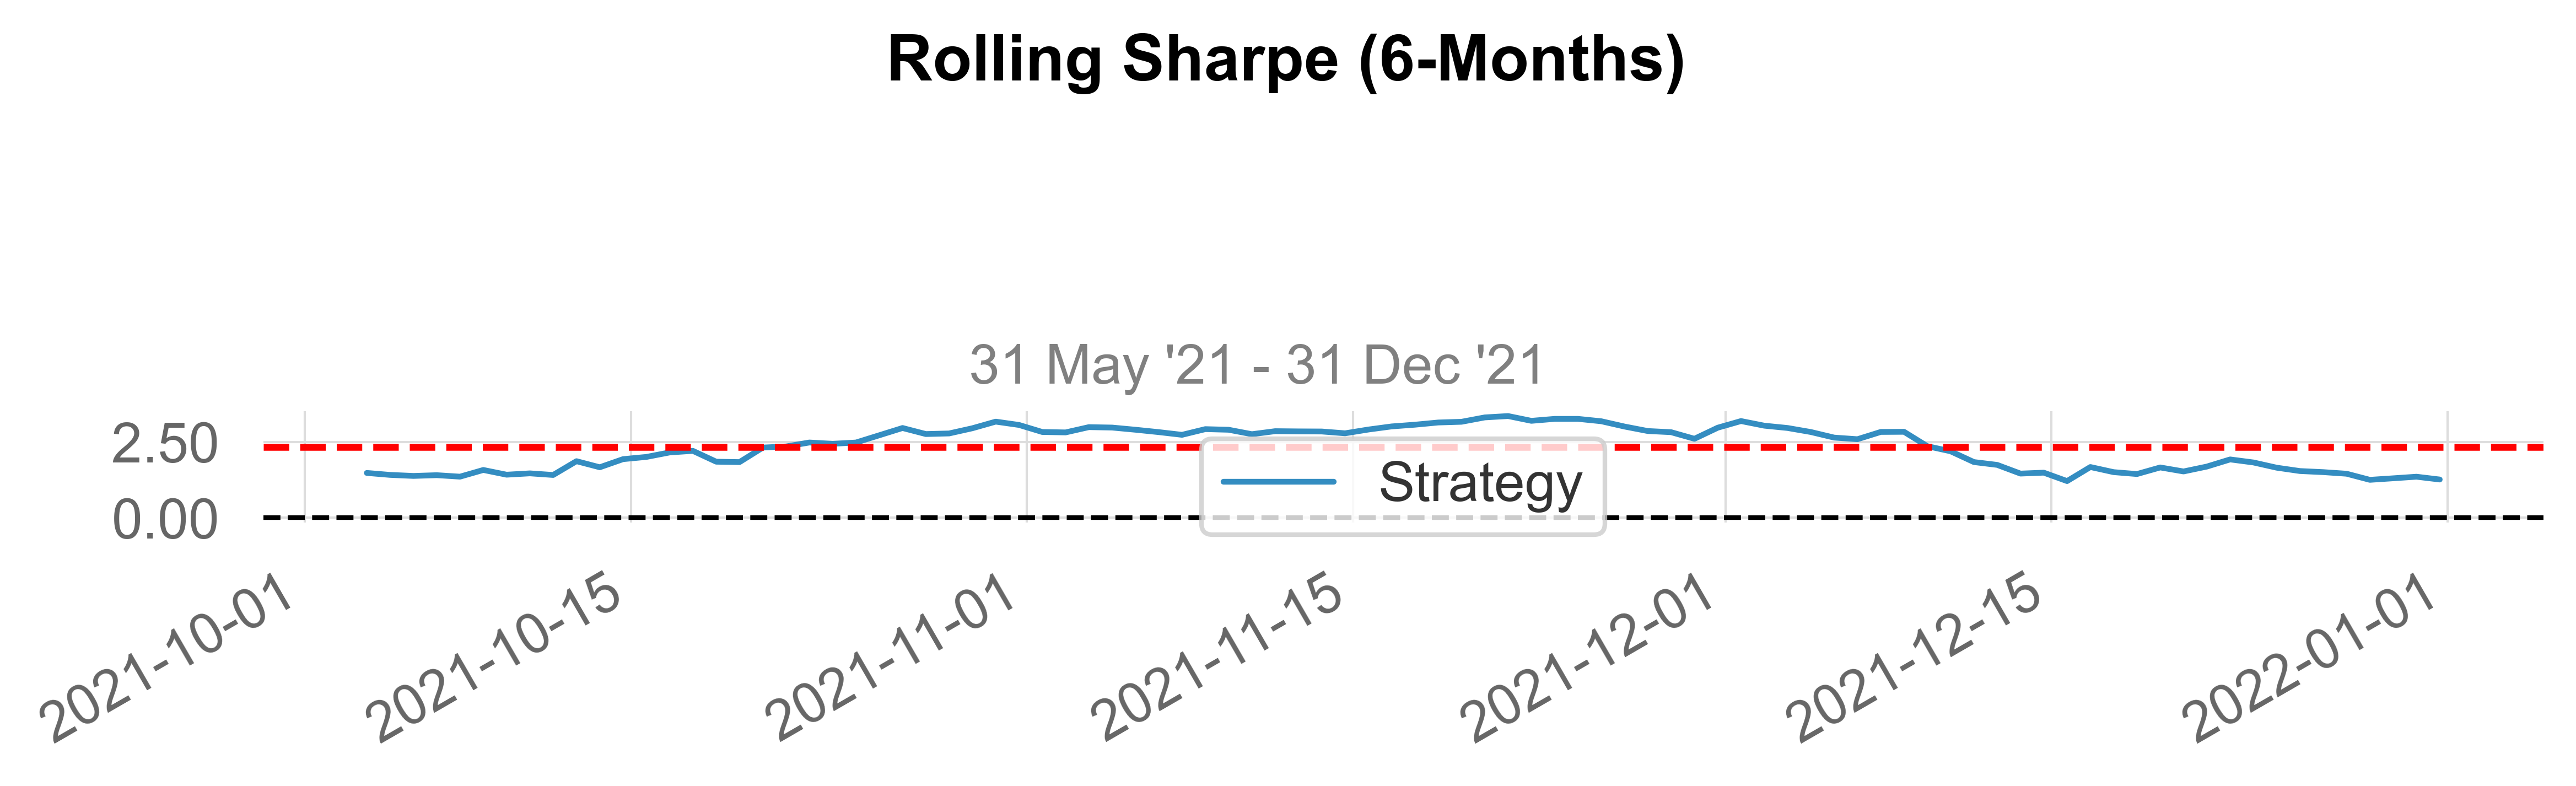

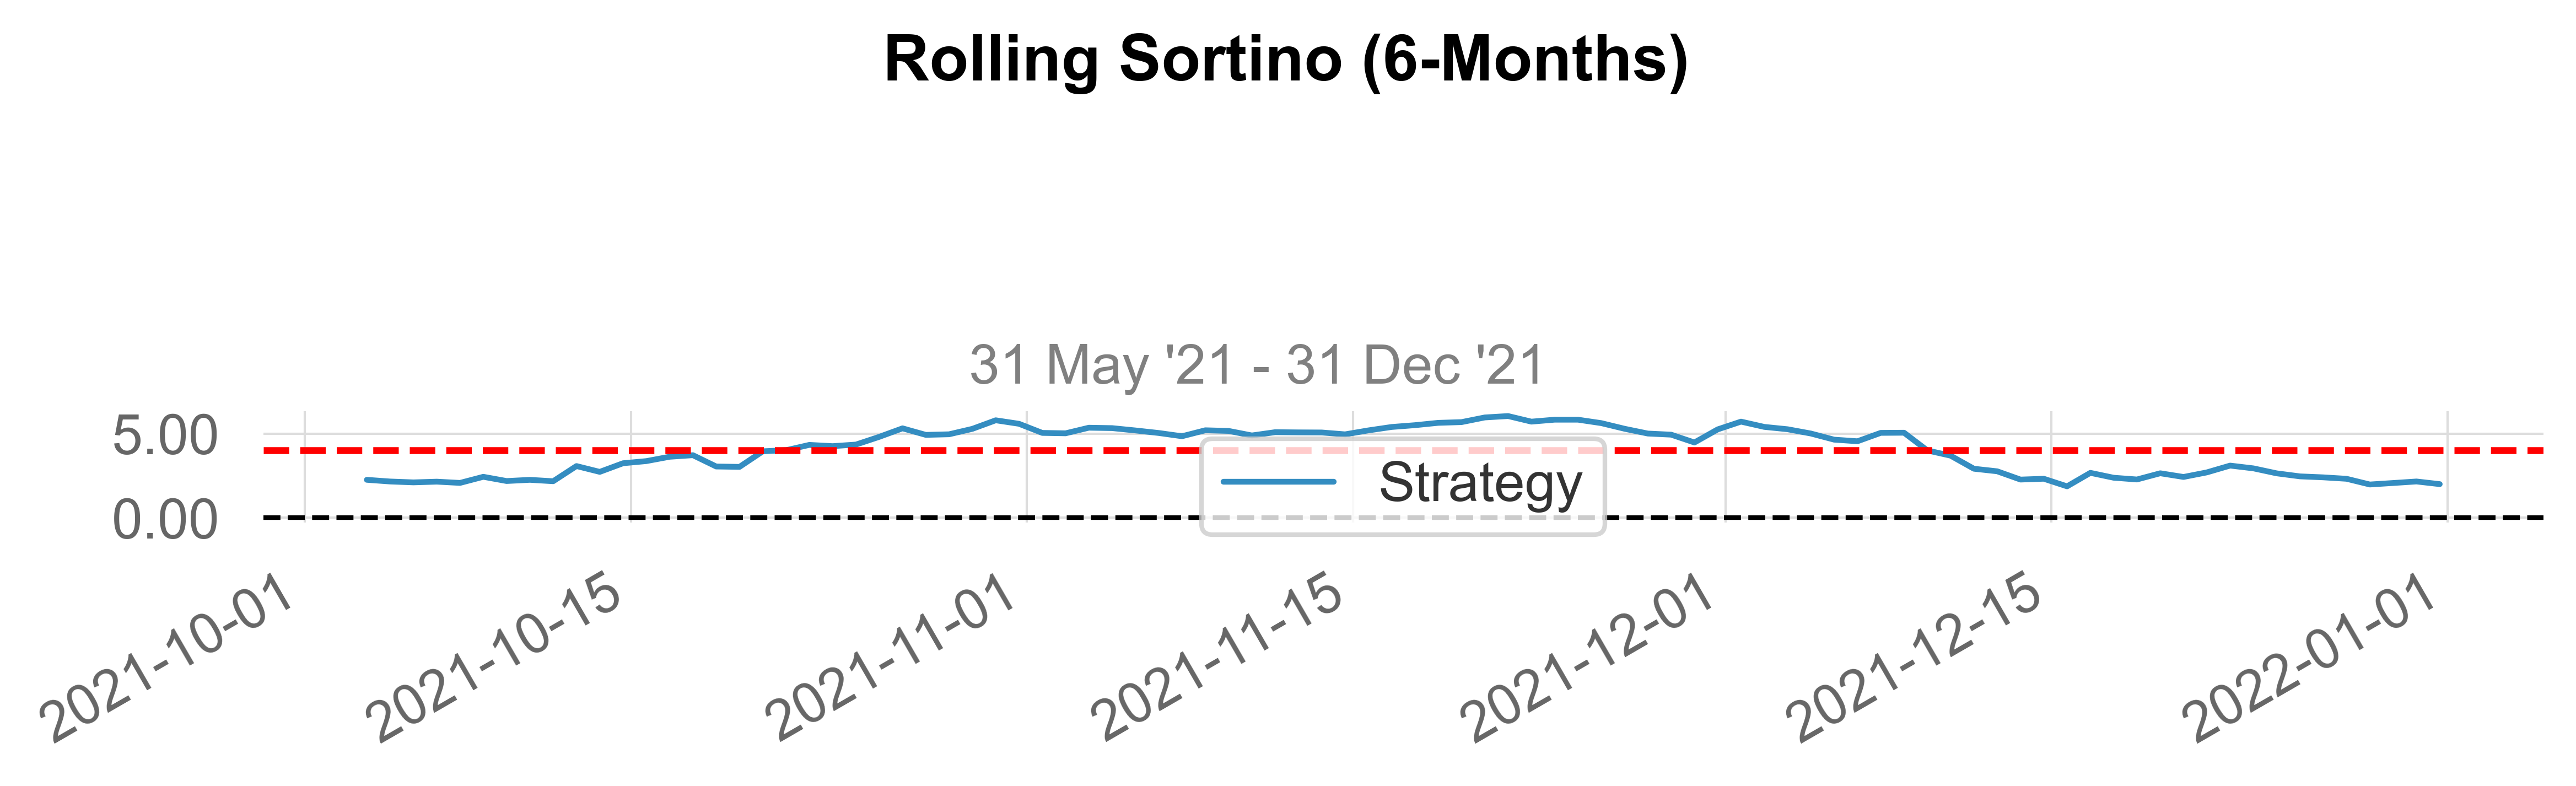

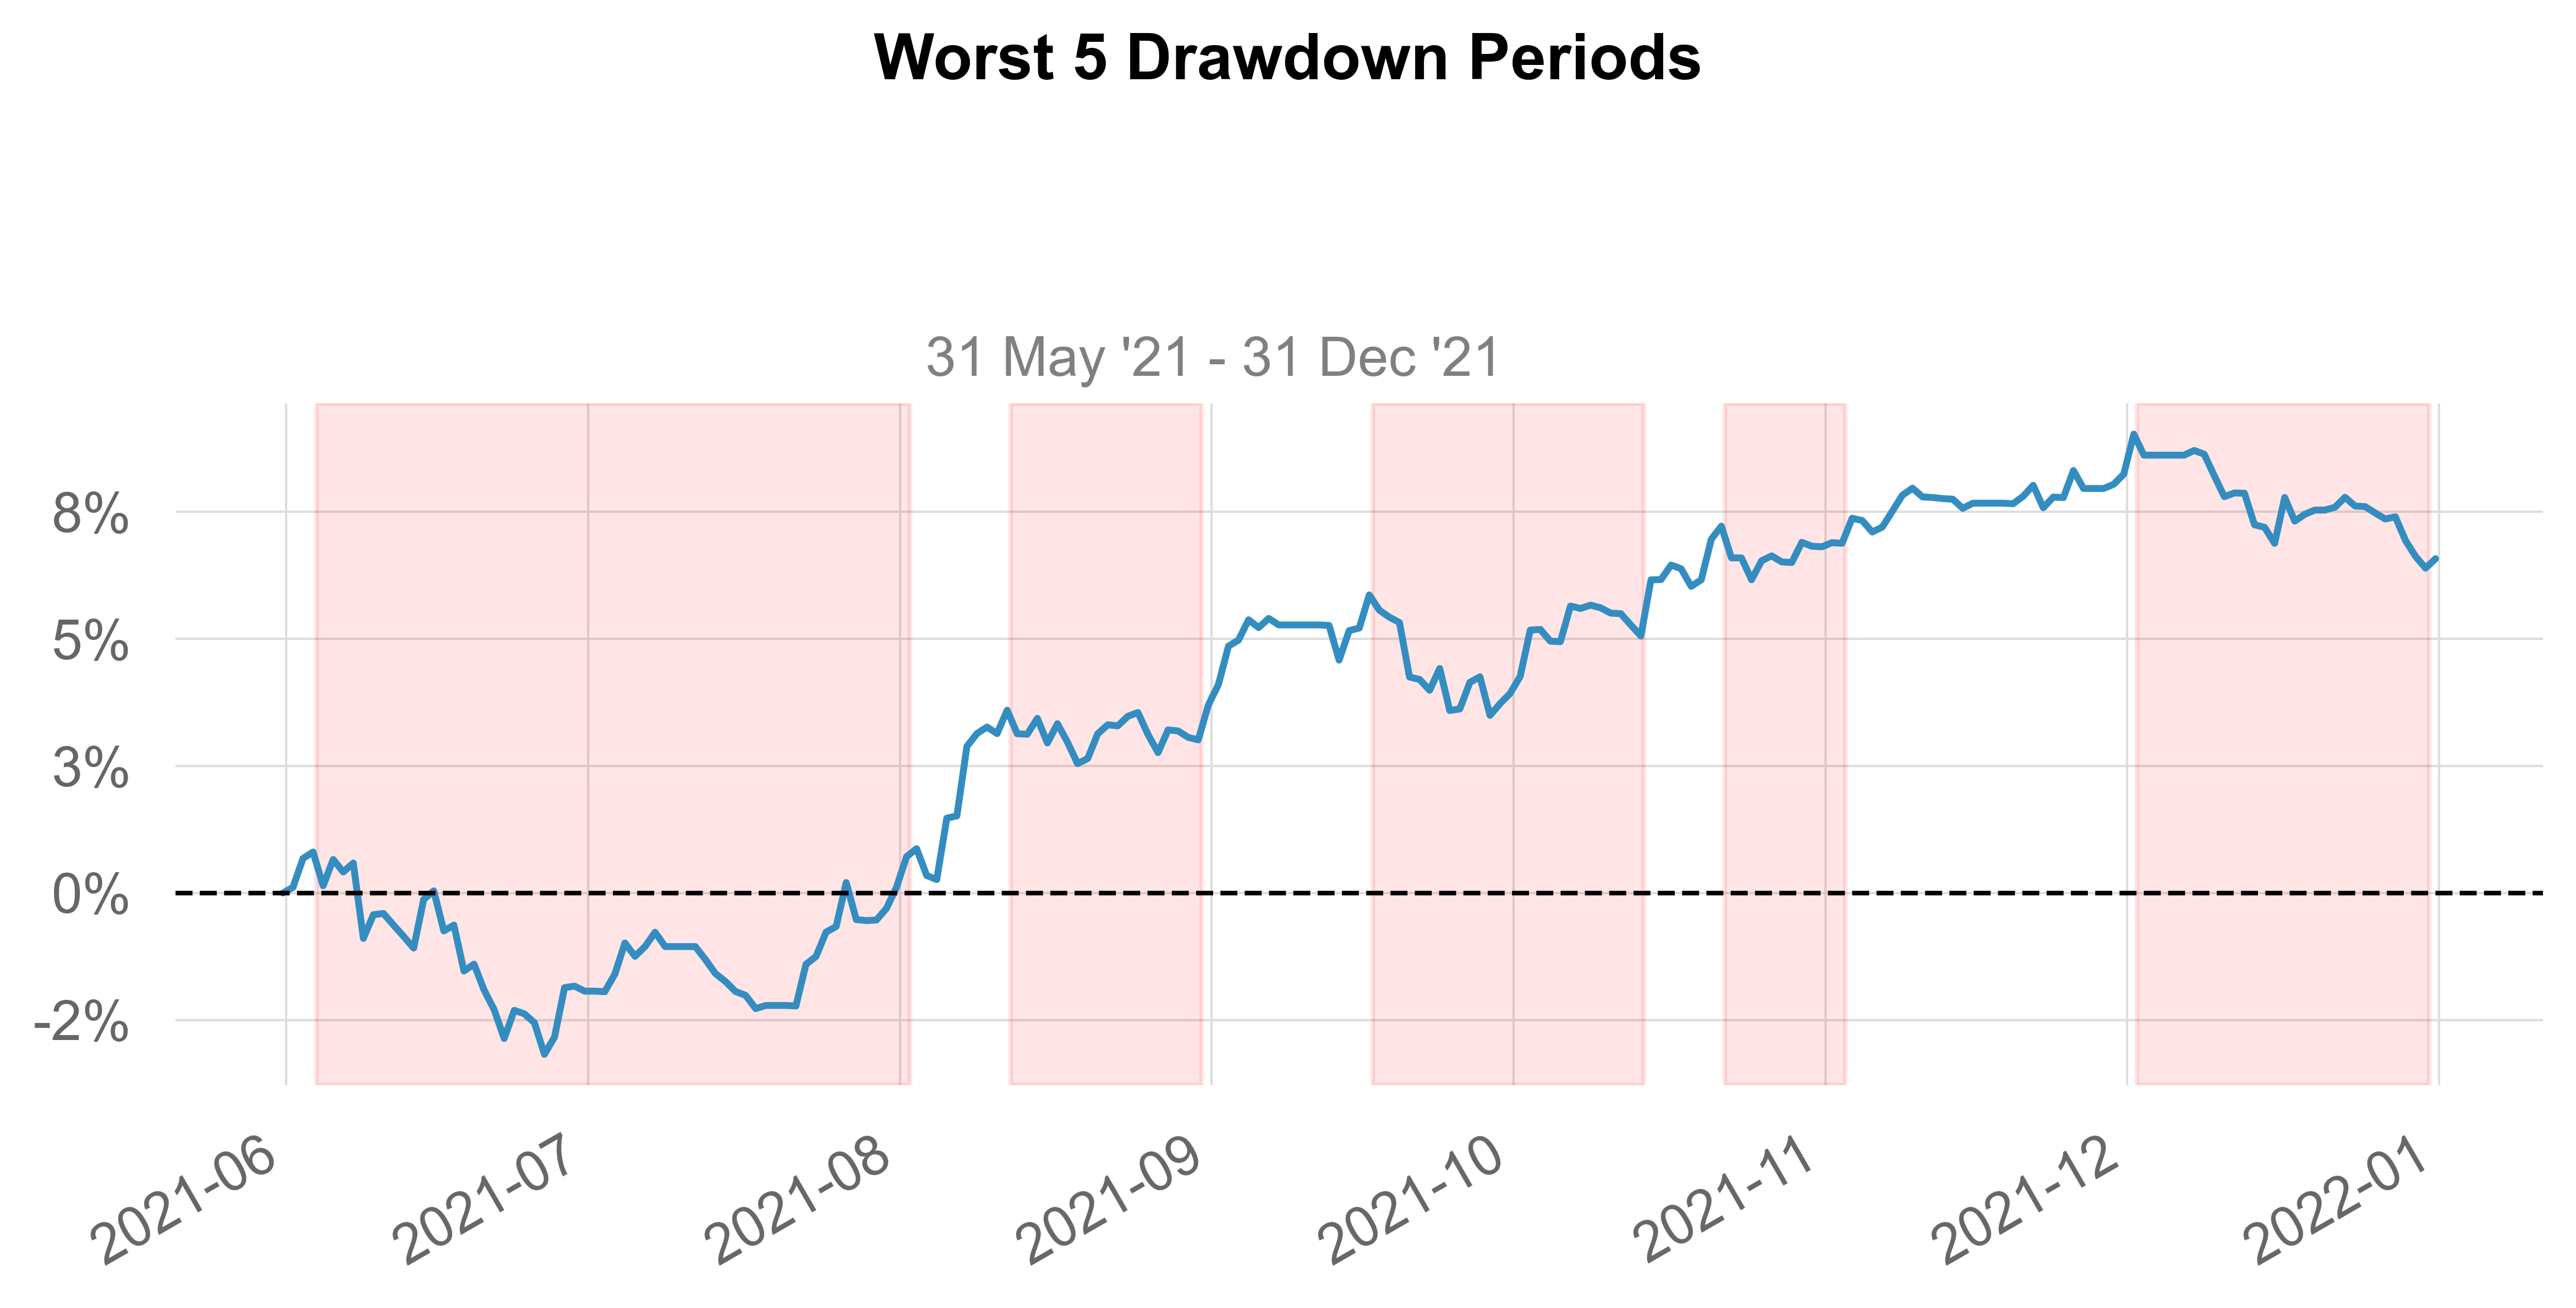

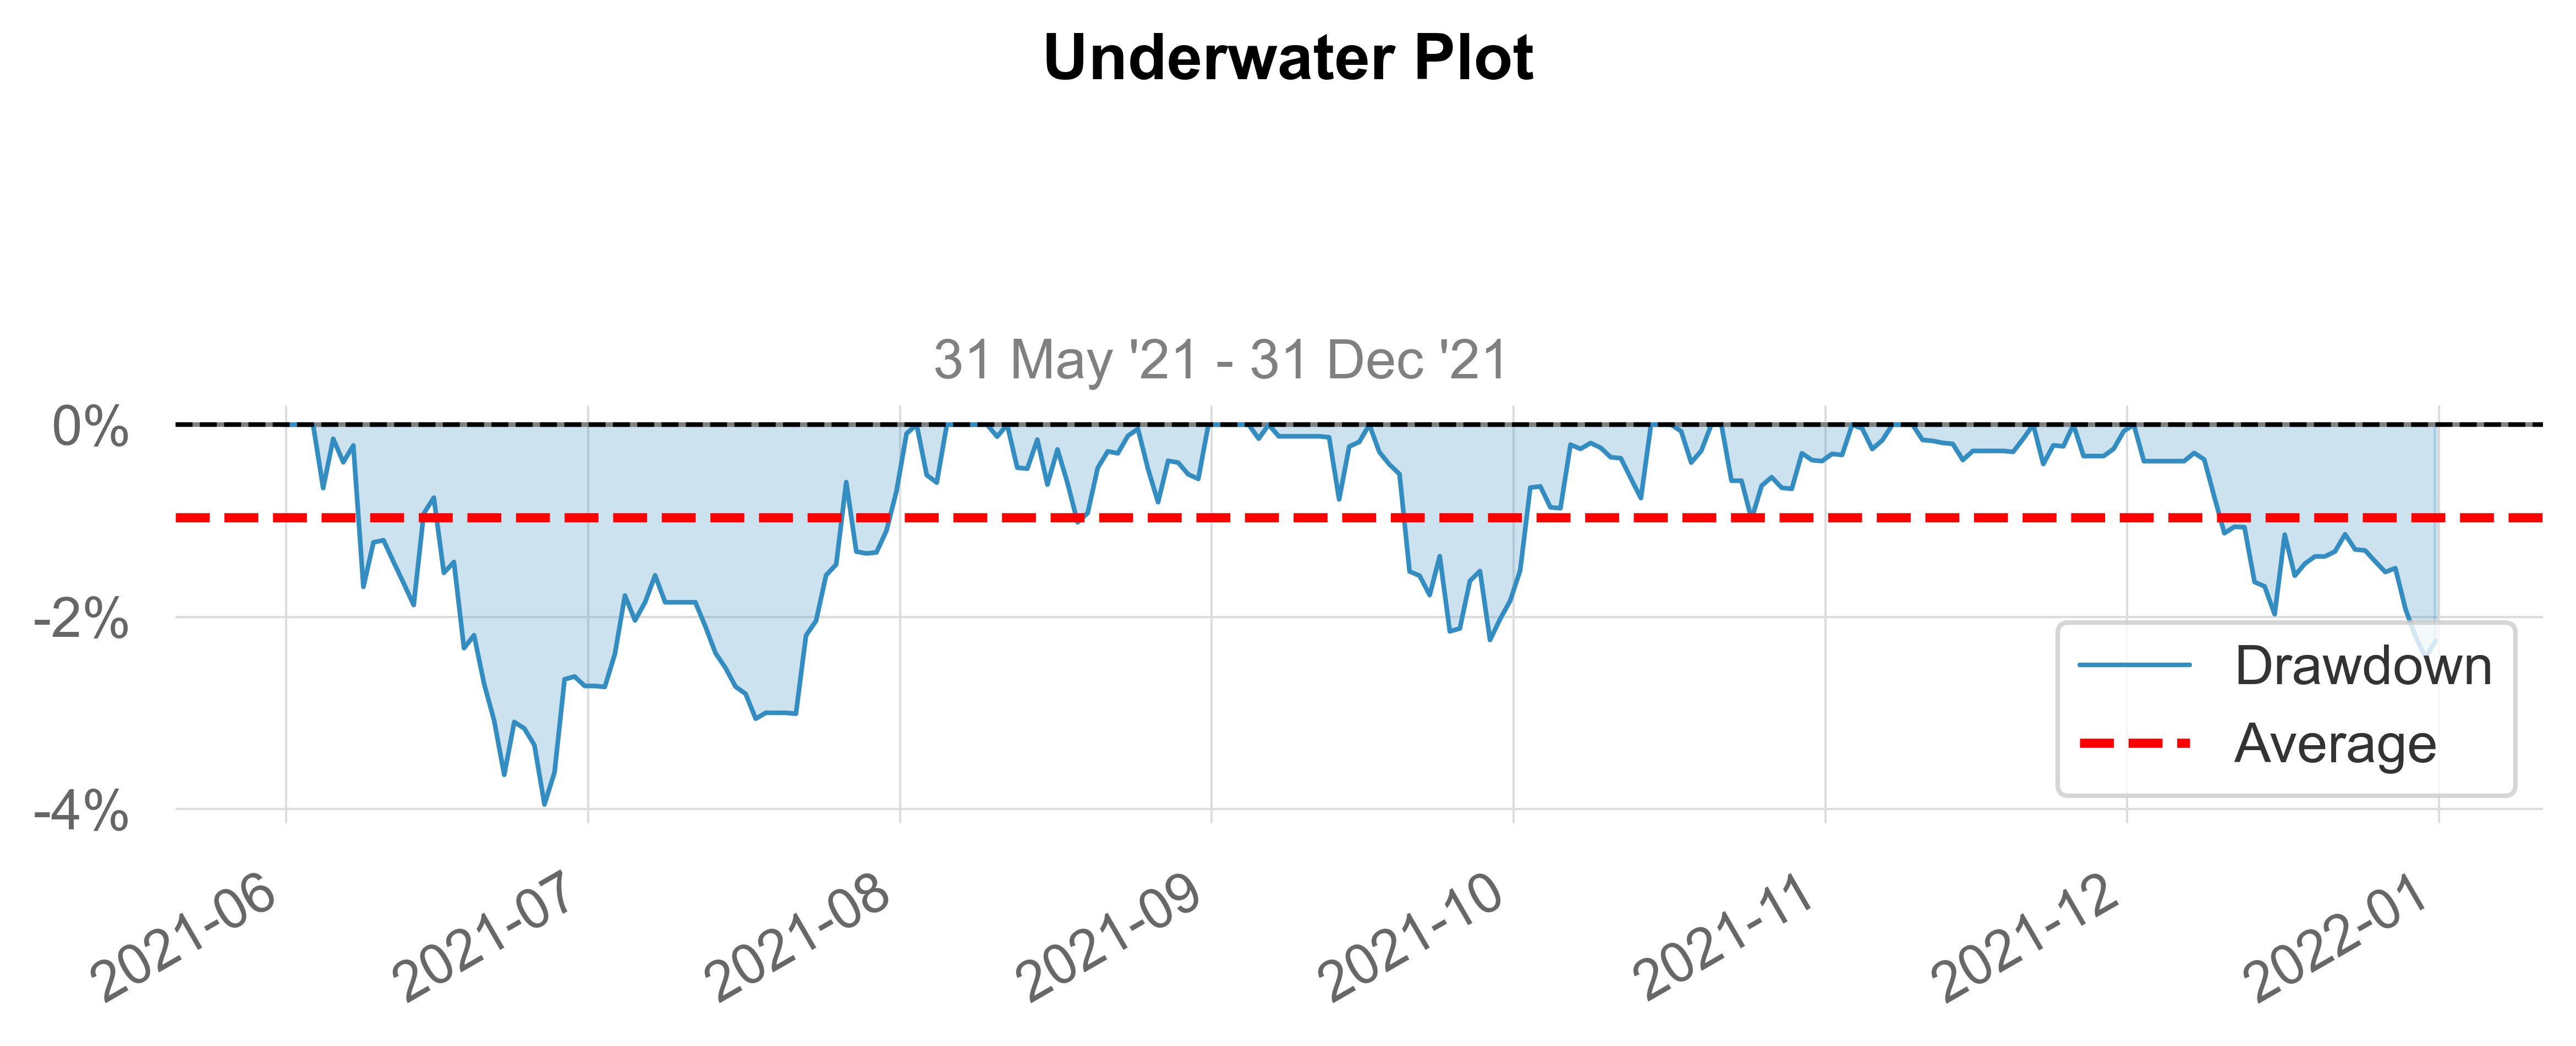

/Users/alexurbs/Library/Caches/pypoetry/virtualenvs/trade-executor-zDrfc5oV-py3.10/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



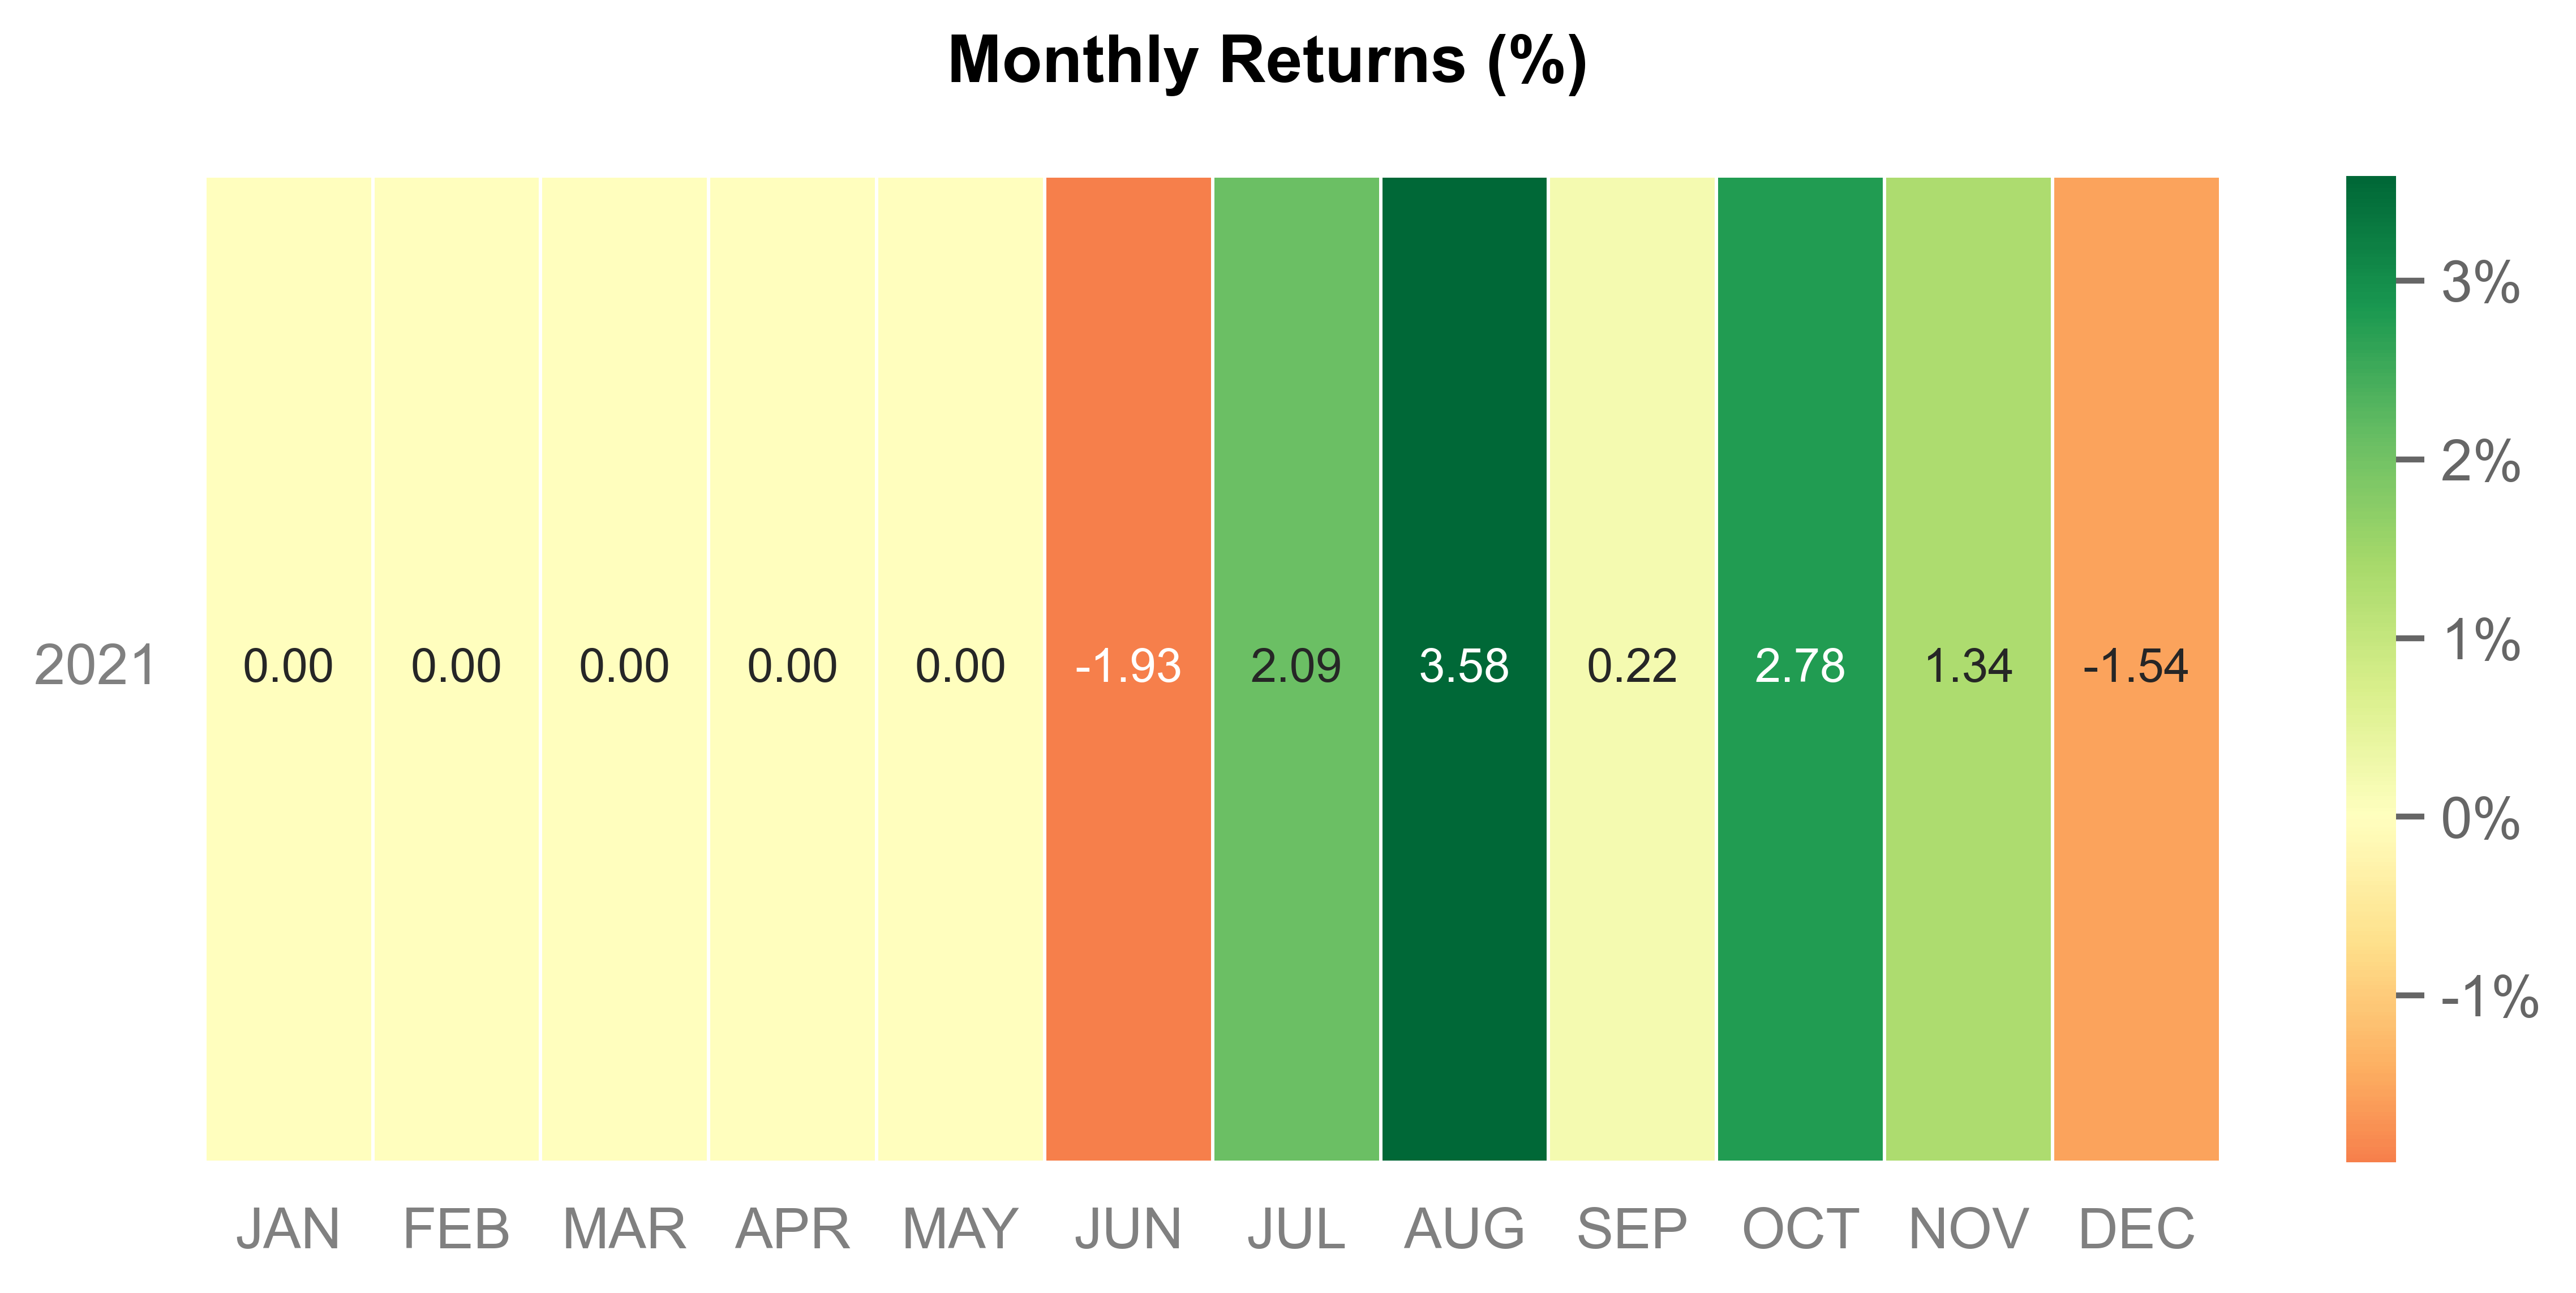

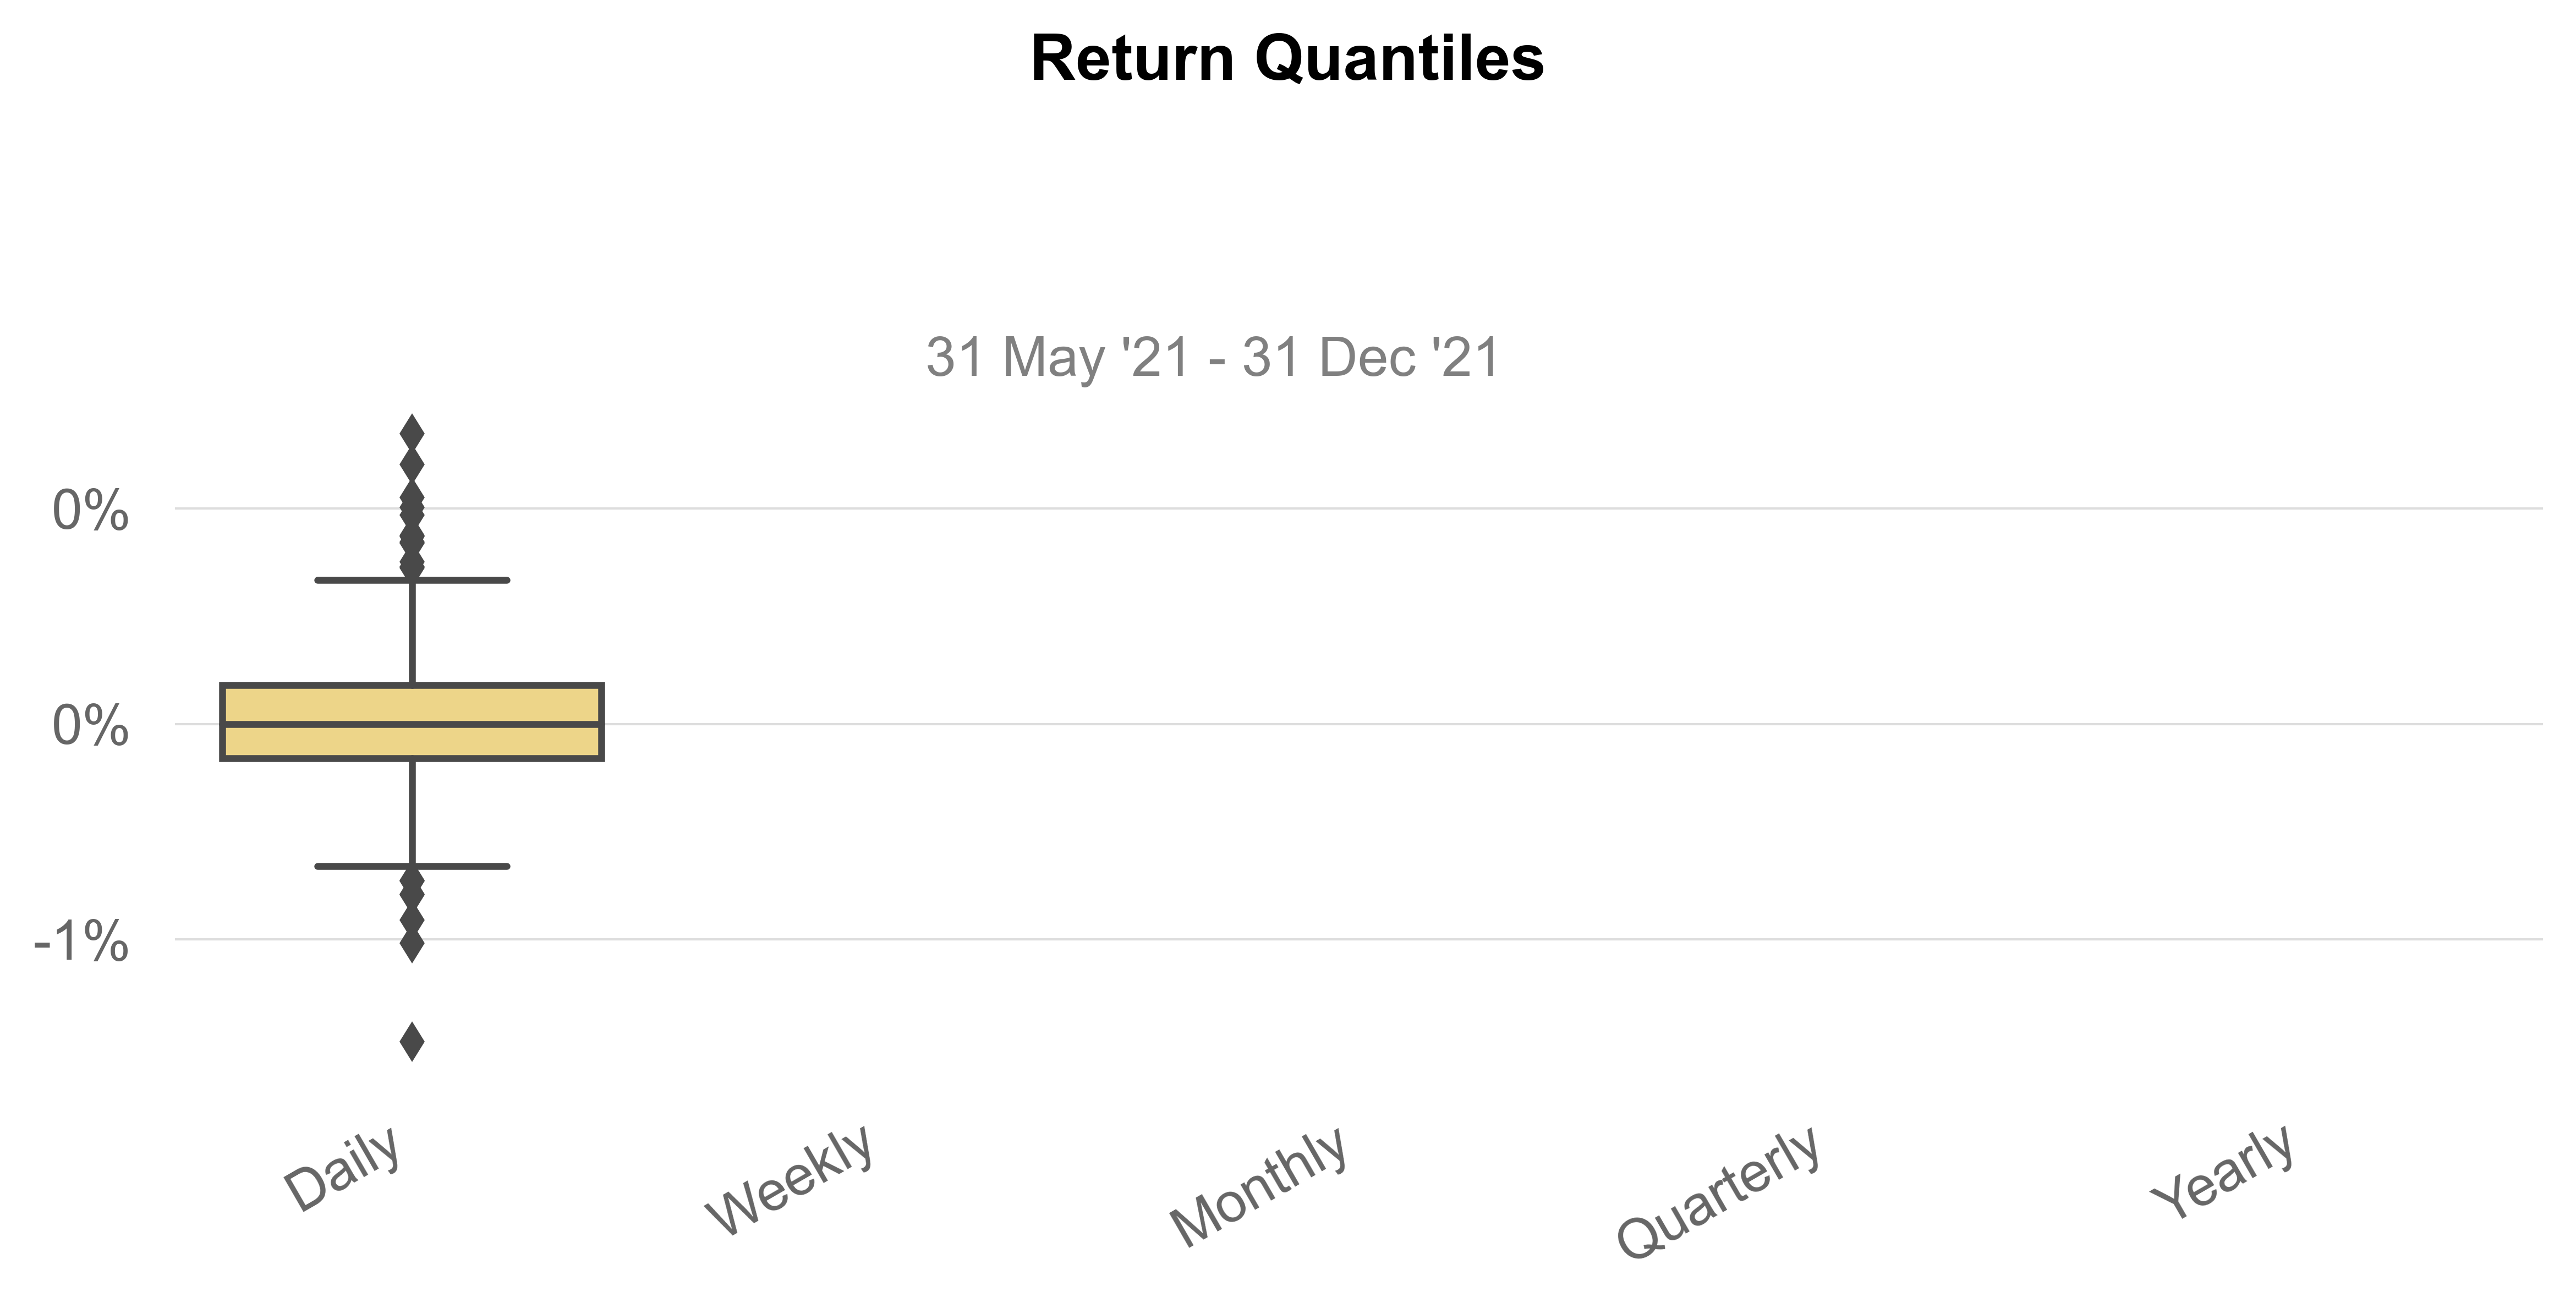

In [34]:
summary.get_full_report()

## Working with the stats yourself

Advanced users can generate the daily returns themselves and analyze it any way they wish. This is shown below.

Note again: you must quantstats installed e.g. `poetry install -E quantstats` and have provided `state` as an argument to `calculate_summary_statistics()`

In [35]:
from tradeexecutor.visual.equity_curve import get_daily_returns

daily_returns = get_daily_returns(state)

display(daily_returns.head())
display(daily_returns.tail())

2021-05-31 16:00:00         NaN
2021-06-01 16:00:00    0.001095
2021-06-02 16:00:00    0.005694
2021-06-03 16:00:00    0.001269
2021-06-04 16:00:00   -0.006600
Freq: D, dtype: float64

2021-12-27 16:00:00    0.000411
2021-12-28 16:00:00   -0.004291
2021-12-29 16:00:00   -0.002955
2021-12-30 16:00:00   -0.002197
2021-12-31 16:00:00    0.001752
Freq: D, dtype: float64

# Other visuals

Here, we show the usual trading and benchmark charts

In [36]:
from tradeexecutor.visual.single_pair import visualise_single_pair

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=start_at,
    end_at=end_at)

figure.show()

/Users/alexurbs/Library/Caches/pypoetry/virtualenvs/trade-executor-zDrfc5oV-py3.10/lib/python3.10/site-packages/tradingstrategy/utils/groupeduniverse.py:129: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [37]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=start_at,
    end_at=end_at,
    height=800
)

fig.show()